In [116]:
import pandas as pd
from copy import deepcopy as dc
import itertools
from itertools import combinations
from itertools import permutations
import numpy as np
from scipy.optimize import linprog
import math
import pickle
#from graphviz import Digraph
import time
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random

def get_signature(x):
    return_string = ''
    for ele in list_entite:
        return_string = return_string + str(int(x[ele]))
    return return_string


def simulation(ini_d_s, ini_c_s, nb_ite):
    """
    initial_discrete_state = '100'
    initial_domain = [0.1,0.2,0.3]
    """
    nb_dim = len(ini_c_s)
    return_series = np.zeros((1, nb_dim))
    times = np.zeros((1, 1))
    count = 0
    for dim_i in range(nb_dim):
        return_series[0][dim_i] = int(ini_d_s[dim_i]) + ini_c_s[dim_i]
    times[0][0] = 0
    d_s = ini_d_s
    c_s = ini_c_s.copy()
    for num_ite in range(nb_ite):
        # instant transition
        instant_transition = True
        current_d_s = dc(d_s)
        c_count = 0
        while instant_transition:
            instant_transition = False
            for dim_i in range(nb_dim):
                if c_s[dim_i] == 1 and classify_boundary(d_s, dim_i, 1) == 'output':
                    instant_transition = True
                    c_s[dim_i] = 0
                    d_s = d_s[0:dim_i] + str(int(d_s[dim_i]) + 1) + d_s[dim_i + 1:]
                    break
                elif c_s[dim_i] == 0 and classify_boundary(d_s, dim_i, -1) == 'output':
                    instant_transition = True
                    c_s[dim_i] = 1
                    d_s = d_s[0:dim_i] + str(int(d_s[dim_i]) - 1) + d_s[dim_i + 1:]
                    break
            c_count = c_count + 1
            #             print(d_s)
            if c_count > 1 and current_d_s == d_s:
                return (return_series, times)
        delta_t = math.inf
        first_touch_dim = nb_dim
        first_touch_sign = 0
        one_return_series = np.zeros((1, nb_dim))
        one_times = np.zeros((1, 1))
        set_att = []
        for dim_i in range(nb_dim):
            if c_s[dim_i] == 1 and classify_boundary(d_s, dim_i, 1) == 'attractif':
                set_att = set_att + [dim_i]
            elif c_s[dim_i] == 0 and classify_boundary(d_s, dim_i, -1) == 'attractif':
                set_att = set_att + [dim_i]
        if len(set_att) == nb_dim:
            return (return_series, times)
        for dim_i in range(nb_dim):
            if dim_i not in set_att:
                speed = get_celerity(d_s, dim_i)
                if speed > 0:
                    delta = (1 - c_s[dim_i]) / speed
                    sign = 1
                elif speed < 0:
                    delta = (0 - c_s[dim_i]) / speed
                    sign = 0
                elif speed == 0:
                    delta = math.inf
                if delta < delta_t:
                    delta_t = delta
                    first_touch_dim = dim_i
                    first_touch_sign = sign
        # check if two boundary are reached at the same time
        for dim_i in range(nb_dim):
            if dim_i not in set_att:
                speed = get_celerity(d_s, dim_i)
                if speed > 0:
                    delta = (1 - c_s[dim_i]) / speed
                    sign = 1
                elif speed < 0:
                    delta = (0 - c_s[dim_i]) / speed
                    sign = 0
                elif speed == 0:
                    delta = math.inf
                if delta == delta_t and dim_i != first_touch_dim:
                    print('reach two new boundaries at the same time!')

        c_s[first_touch_dim] = first_touch_sign
        count = count + delta_t
        for dim_i in range(nb_dim):
            if dim_i not in set_att and dim_i != first_touch_dim:
                speed = get_celerity(d_s, dim_i)
                c_s[dim_i] = c_s[dim_i] + delta_t * speed
            one_return_series[0][dim_i] = int(d_s[dim_i]) + c_s[dim_i]
        #         print('discrete state:',d_s)
        #         print('continuous state:',c_s)
        #         print('***********************')
        one_times[0][0] = count
        return_series = np.vstack([return_series, one_return_series])
        times = np.vstack([times, one_times])
    return (return_series, times)


def classify_boundary(state, dim, domain):
    """
    state: '010'
    dim: 2
    domain: 1/0/-1
    """
    current_row = celerities.query('signature == @state')
    speed = current_row['c_' + list_entite[dim]].values[0]
    if domain == 0:
        return 'interior'
    elif domain == 1:
        if speed > 0:
            if int(state[dim]) == max_level[list_entite[dim]]:
                return 'attractif'
            else:
                upper_discrete_state = state
                upper_discrete_state = list(upper_discrete_state)
                upper_discrete_state[dim] = str(int(upper_discrete_state[dim]) + 1)
                upper_discrete_state = "".join(upper_discrete_state)
                upper_speed = celerities.query('signature == @upper_discrete_state')['c_' + list_entite[dim]].values[0]
                if upper_speed <= 0:
                    return 'attractif'
                elif upper_speed > 0:
                    return 'output'
        elif speed == 0:
            return 'neutral'
        elif speed < 0:
            return 'input'
    elif domain == -1:
        if speed < 0:
            if int(state[dim]) == 0:
                return 'attractif'
            else:
                lower_discrete_state = state
                lower_discrete_state = list(lower_discrete_state)
                lower_discrete_state[dim] = str(int(lower_discrete_state[dim]) - 1)
                lower_discrete_state = "".join(lower_discrete_state)
                lower_speed = celerities.query('signature == @lower_discrete_state')['c_' + list_entite[dim]].values[0]
                if lower_speed >= 0:
                    return 'attractif'
                elif lower_speed < 0:
                    return 'output'
        elif speed == 0:
            return 'neutral'
        elif speed > 0:
            return 'input'


def get_celerity(state, dim):
    current_row = celerities.query('signature == @state')
    speed = current_row['c_' + list_entite[dim]].values[0]
    return speed


def get_transition_matrix(state, first_domain, second_domain):
    """
    state: '0101'
    first_domain(second_domain): [0,-1,1,0]
    """
    # get first reach dimension
    first_reach_dim = len(second_domain) + 1
    for num_dim in range(len(second_domain)):
        if second_domain[num_dim] in [-1, 1] and first_domain[num_dim] != second_domain[num_dim]:
            first_reach_dim = num_dim
            break
    # Calculate delta t
    speed = get_celerity(state, first_reach_dim)
    if first_domain[first_reach_dim] in [1, -1]:
        if second_domain[first_reach_dim] == 1:
            delta_cons = 1 / speed
            delta_var = 0
        elif second_domain[first_reach_dim] == -1:
            delta_cons = (-1) / speed
            delta_var = 0
    else:
        if second_domain[first_reach_dim] == 1:
            delta_cons = 1 / speed
            delta_var = (-1) / speed
        elif second_domain[first_reach_dim] == -1:
            delta_cons = 0
            delta_var = (-1) / speed
    # calculate transition matrix
    nb_dim = len(second_domain)
    # the supplementary dimension is 1
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    t_m[nb_dim][nb_dim] = 1
    delta1 = time.time()
    for num_dim in range(nb_dim):
        if num_dim == first_reach_dim:
            # for first reached dimension
            if second_domain[first_reach_dim] == 1:
                t_m[first_reach_dim][nb_dim] = 1
            elif second_domain[first_reach_dim] == -1:
                t_m[first_reach_dim][nb_dim] = 0
        else:
            # slide
            if second_domain[num_dim] in [-1, 1] and second_domain[num_dim] == first_domain[num_dim]:
                t_m[num_dim][num_dim] = 1
            else:
                # normal tranform x_new = x + c * delta_t
                current_speed = get_celerity(state, num_dim)
                t_m[num_dim][num_dim] = 1
                t_m[num_dim][first_reach_dim] = current_speed * delta_var
                t_m[num_dim][nb_dim] = current_speed * delta_cons
    return t_m


def get_transition_cross_state(state1, state2):
    """
    state1: '0101'
    state2: '0100'
    """
    nb_dim = len(state1)
    # initialize transiton matrix
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    t_m[nb_dim][nb_dim] = 1
    for dim_i in range(nb_dim):
        t_m[dim_i][dim_i] = 1
        if state2[dim_i] > state1[dim_i]:
            t_m[dim_i][nb_dim] = -1
        elif state2[dim_i] < state1[dim_i]:
            t_m[dim_i][nb_dim] = 1
    return t_m


def get_fixed_point(A):
    nb_dim = A.shape[0]
    iden = np.zeros((nb_dim, nb_dim))
    for i_dim in range(nb_dim):
        iden[i_dim][i_dim] = 1
    X = np.subtract(A, iden)
    b = np.zeros(nb_dim)
    fixed_point = np.linalg.solve(X, b)
    return fixed_point


def get_constraint1(discrete_domain):
    dim_free = []
    for one_dim in range(len(discrete_domain)):
        if discrete_domain[one_dim] not in [-1, 1]:
            dim_free = dim_free + [one_dim]
    last_constraint_a = np.zeros((2 * len(dim_free), len(discrete_domain)))
    last_constraint_b = np.zeros((2 * len(dim_free), 1))
    for one_dim in range(len(dim_free)):
        last_constraint_a[one_dim * 2][dim_free[one_dim]] = 1
        last_constraint_a[one_dim * 2 + 1][dim_free[one_dim]] = -1
        last_constraint_b[one_dim * 2][0] = 1
        last_constraint_b[one_dim * 2 + 1][0] = 0
    return last_constraint_a, last_constraint_b


def get_stable_zone(one_trajectory):
    len_state = len(one_trajectory)
    nb_dim = len(list_entite)
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    cons_a = np.zeros((1, nb_dim))
    cons_b = np.ones((1, 1))
    for dim_i in range(nb_dim + 1):
        t_m[dim_i][dim_i] = 1
    for i_state in range(len_state):
        current_discrete_state = list(one_trajectory[i_state].keys())[0]
        if i_state < len_state - 1:
            post_discrete_state = list(one_trajectory[i_state + 1].keys())[0]
        current_discrete_trajectory = one_trajectory[i_state][current_discrete_state]
        len_domain = len(current_discrete_trajectory)
        for i_domain in range(len_domain):
            # calculate current constraints
            current_cons_a, current_cons_b = get_constraint1(current_discrete_trajectory[i_domain])
            new_cons_a = np.matmul(current_cons_a, t_m[:-1, :-1])
            temp_b = np.matmul(current_cons_a, t_m[:-1, -1])
            new_cons_b = current_cons_b - temp_b.reshape(temp_b.shape[0], 1)
            cons_a = np.vstack([cons_a, new_cons_a])
            cons_b = np.vstack([cons_b, new_cons_b])
            # calculate next transition matrix
            if i_domain < len_domain - 1:
                current_transition_matrix = get_transition_matrix(current_discrete_state,
                                                                  current_discrete_trajectory[i_domain],
                                                                  current_discrete_trajectory[i_domain + 1])
                t_m = np.matmul(current_transition_matrix, t_m)
            elif i_domain == len_domain - 1 and i_state < len_state - 1:
                current_transition_matrix = get_transition_cross_state(current_discrete_state, post_discrete_state)
                t_m = np.matmul(current_transition_matrix, t_m)
    # regularise the constrains in the first discrete domain
    first_discrete_state = list(one_trajectory[0].keys())[0]
    first_domain = one_trajectory[0][first_discrete_state][0]
    for num_dim in range(len(first_domain)):
        if first_domain[num_dim] == -1:
            cons_a[:, num_dim] = 0
        elif first_domain[num_dim] == 1:
            cons_b = cons_b - cons_a[:, num_dim].reshape(cons_a[:, num_dim].shape[0], 1)
            cons_a[:, num_dim] = 0
    c = np.zeros((cons_a.shape[1],))
    res = linprog(c, cons_a, cons_b)
    if res.success == False:
        return False, [cons_a, cons_b]
    else:
        return True, [cons_a, cons_b]


def dfs(graph, trace, start):
    global cycles
    global reached
    trace = dc(trace)
    if start in trace:
        index = trace.index(start)
        tmp = [i for i in trace[index:]]
        temp_bool = False
        for ele in cycles:
            if same(ele, tmp) == True:
                temp_bool = True
        if temp_bool == False:
            cycles = cycles + [tmp]
        return
    if start not in reached:
        reached = reached + [start]
    trace.append(start)
    for i in graph[start]:
        dfs(graph, trace, i)


def same(list1, list2):
    if len(list1) != len(list2):
        return False
    elif list1[0] not in list2:
        return False
    else:
        length = len(list1)
        first = list2.index(list1[0])
        for i in range(length):
            if list1[i] != list2[(first + i) % length]:
                return False
        return True

def get_next_state(cycle, state):
    len_cycle = len(cycle)
    i_c = cycle.index(state)
    if i_c < len_cycle - 1:
        return cycle[i_c + 1]
    elif i_c == len_cycle - 1:
        return cycle[0]


def dfs_discrete_all(domain, s_domain, state, cycle, t_m, s_z):
    """
    domain: [1,-1,1]
    s_domain: current discrete trajectory without domain [{'01':[[-1,1],[0,-1]]},{}]
    state: discrete state of domain
    cycle: the cycle of discrete state
    t_m: transition matrix without considering domain
    s_z: stable zone without considering domain
    """
    global list_discrete_trajectory
    global list_transition_matrix
    global list_stable_zone
    global list_cycle
    s_domain = dc(s_domain)
    t_m = dc(t_m)
    s_z = dc(s_z)
    cycle = dc(cycle)
    domain = dc(domain)
    state = dc(state)
    #     print('s_domain',s_domain)
    #     print('domain',domain)
    #     print('state',state)
    #     print('cycle',cycle)
    #     print('t_m',t_m)
    #     print('s_z',s_z)

    if len(cycle) > 1 and state == cycle[0]:
        list_discrete_trajectory = list_discrete_trajectory + [s_domain]
        list_transition_matrix = list_transition_matrix + [t_m]
        list_stable_zone = list_stable_zone + [s_z]
        list_cycle = list_cycle + [cycle]
        return
    elif len(cycle) > 1 and state in cycle[:-1] and state != cycle[0]:
        return
    # step1: add domain to s_domain
    if len(s_domain) == 0:
        new_dict = dict()
        new_dict[state] = [dc(domain)]
        s_domain = [new_dict]
        s_z_a, s_z_b = get_constraint1(domain)
        s_z = [s_z_a, s_z_b]
        cycle = cycle + [dc(state)]

        # instant transition
        instant = False
        for i_dim in range(len(domain)):
            if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'output':
                next_domain = dc(domain)
                next_domain[i_dim] = -1
                next_state = dc(state)
                next_state = list(next_state)
                next_state[i_dim] = str(int(next_state[i_dim]) + 1)
                next_state = "".join(next_state)
                dfs_discrete_all(next_domain, s_domain, next_state, cycle, t_m, s_z)
                instant = True
                break
            elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'output':
                next_domain = dc(domain)
                next_domain[i_dim] = 1
                next_state = dc(state)
                next_state = list(next_state)
                next_state[i_dim] = str(int(next_state[i_dim]) - 1)
                next_state = "".join(next_state)
                dfs_discrete_all(next_domain, s_domain, next_state, cycle, t_m, s_z)
                instant = True
                break

        # non instant transition
        if instant == False:
            for i_dim in range(len(domain)):
                if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'input':
                    domain[i_dim] = 0
                elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'input':
                    domain[i_dim] = 0
            for i_dim in range(len(domain)):
                if domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'output':
                    new_domain = dc(domain)
                    new_domain[i_dim] = 1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
                elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'output':
                    new_domain = dc(domain)
                    new_domain[i_dim] = -1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
                elif domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'attractif':
                    new_domain = dc(domain)
                    new_domain[i_dim] = 1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
                elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'attractif':
                    new_domain = dc(domain)
                    new_domain[i_dim] = -1
                    dfs_discrete_all(new_domain, s_domain, state, cycle, t_m, s_z)
    else:
        # calculate new transition matrix
        current_state = list(s_domain[-1].keys())[0]
        if current_state == state:
            last_domain = s_domain[-1][current_state][-1]
            temp_t_m = get_transition_matrix(state, last_domain, domain)
        elif current_state != state:
            temp_t_m = get_transition_cross_state(current_state, state)
        #         print('temp_t_m',temp_t_m)
        new_t_m = np.matmul(temp_t_m, t_m)
        # calculate new constraint
        c_a, c_b = get_constraint1(domain)
        new_a = np.matmul(c_a, new_t_m[:-1, :-1])
        temp_b = np.matmul(c_a, new_t_m[:-1, -1])
        new_b = c_b - temp_b.reshape(temp_b.shape[0], 1)
        # regulate the constraint considering the first domain
        first_state = cycle[0]
        first_domain = s_domain[0][first_state][0]
        for num_dim in range(len(first_domain)):
            if first_domain[num_dim] == -1:
                new_a[:, num_dim] = 0
            elif first_domain[num_dim] == 1:
                new_b = new_b - new_a[:, num_dim].reshape(new_a[:, num_dim].shape[0], 1)
                new_a[:, num_dim] = 0
        #         print('new_a',new_a)
        #         print('new_b',new_b)
        #         print('************')
        new_s_z_a = np.vstack([s_z[0], new_a])
        new_s_z_b = np.vstack([s_z[1], new_b])
        c = np.zeros((new_s_z_a.shape[1],))
        try:
            res = linprog(c, new_s_z_a, new_s_z_b)
            add_bool = res.success
        except:
            add_bool = False
        if add_bool == False:
            # path end without returning a discrete trajectory
            return
        else:
            # add domain to s_domain
            if current_state == state:
                s_domain[-1][state] = s_domain[-1][state] + [dc(domain)]
            elif current_state != state:
                new_dict = dict()
                new_dict[state] = [dc(domain)]
                s_domain = s_domain + [new_dict]
                cycle = cycle + [dc(state)]
            # choose all possible next domain

            # instant transition
            instant = False
            for i_dim in range(len(domain)):
                if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'output':
                    next_domain = dc(domain)
                    next_domain[i_dim] = -1
                    next_state = dc(state)
                    next_state = list(next_state)
                    next_state[i_dim] = str(int(next_state[i_dim]) + 1)
                    next_state = "".join(next_state)
                    dfs_discrete_all(next_domain, s_domain, next_state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    instant = True
                    break
                elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'output':
                    next_domain = dc(domain)
                    next_domain[i_dim] = 1
                    next_state = dc(state)
                    next_state = list(next_state)
                    next_state[i_dim] = str(int(next_state[i_dim]) - 1)
                    next_state = "".join(next_state)
                    dfs_discrete_all(next_domain, s_domain, next_state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    instant = True
                    break

            # non instant transition
            if instant == False:
                for i_dim in range(len(domain)):
                    if domain[i_dim] == 1 and classify_boundary(state, i_dim, 1) == 'input':
                        domain[i_dim] = 0
                    elif domain[i_dim] == -1 and classify_boundary(state, i_dim, -1) == 'input':
                        domain[i_dim] = 0
                for i_dim in range(len(domain)):
                    if domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'output':
                        new_domain = dc(domain)
                        new_domain[i_dim] = 1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'output':
                        new_domain = dc(domain)
                        new_domain[i_dim] = -1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    elif domain[i_dim] != 1 and classify_boundary(state, i_dim, 1) == 'attractif':
                        new_domain = dc(domain)
                        new_domain[i_dim] = 1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
                    elif domain[i_dim] != -1 and classify_boundary(state, i_dim, -1) == 'attractif':
                        new_domain = dc(domain)
                        new_domain[i_dim] = -1
                        dfs_discrete_all(new_domain, s_domain, state, cycle, new_t_m, [new_s_z_a, new_s_z_b])
    return




One simulation

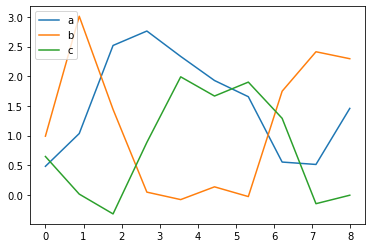

In [15]:
list_entite = ['a','b','c']
max_level = dict()
max_level['a'] = 1
max_level['b'] = 1
max_level['c'] = 1

list_colums = []
list_colums = list_colums + list_entite
for one_ele in list_entite:
    list_colums = list_colums + ['c_'+one_ele]
celerities = pd.DataFrame(columns=list_colums)

sca = 0.8
scmax = 1.7
sab = 1.4
samax = 2.7
sbc = 1.2
sbmax = 3

vac0a0=1
vac0a1=1.9
vac1a0=1.3
vac1a1=0.4
vba0b0=3.8
vba0b1=2.5
vba1b0=2.7
vba1b1=3.3
vcb0c0=1.5
vcb0c1=0.8
vcb1c0=1.9
vcb1c1=1.5

num = 20
initial_state  = (0.5,0.7,0.8)
nb = 10

noise1 = 0.2
noise2 = 0.2
noise3 = 0.2

cac0a0=vac0a0/(sab - 0)
cac0a1=vac0a1/(samax - sab)
cac1a0=vac1a0/(sab - 0)
cac1a1=vac1a1/(samax - sab)
cba0b0=vba0b0/(sbc - 0)
cba0b1=vba0b1/(sbmax - sbc)
cba1b0=vba1b0/(sbc - 0)
cba1b1=vba1b1/(sbmax - sbc)
ccb0c0=vcb0c0/(sca - 0)
ccb0c1=vcb0c1/(scmax -sca)
ccb1c0=vcb1c0/(sca - 0)
ccb1c1=vcb1c1/(scmax -sca)

df1 = pd.DataFrame([[0,0,0,cac0a0,cba0b0,ccb0c0]],columns=list_colums)
df2 = pd.DataFrame([[0,0,1,-cac1a0,cba0b0,ccb0c1]],columns=list_colums)
df3 = pd.DataFrame([[0,1,0,cac0a0,cba0b1,-ccb1c0]],columns=list_colums)
df4 = pd.DataFrame([[0,1,1,-cac1a0,cba0b1,-ccb1c1]],columns=list_colums)
df5 = pd.DataFrame([[1,0,0,cac0a1,-cba1b0,ccb0c0]],columns=list_colums)
df6 = pd.DataFrame([[1,0,1,-cac1a1,-cba1b0,ccb0c1]],columns=list_colums)
df7 = pd.DataFrame([[1,1,0,cac0a1,-cba1b1,-ccb1c0]],columns=list_colums)
df8 = pd.DataFrame([[1,1,1,-cac1a1,-cba1b1,-ccb1c1]],columns=list_colums)

celerities = celerities.append(df1)
celerities = celerities.append(df2)
celerities = celerities.append(df3)
celerities = celerities.append(df4)
celerities = celerities.append(df5)
celerities = celerities.append(df6)
celerities = celerities.append(df7)
celerities = celerities.append(df8)
celerities['signature'] = celerities.apply(get_signature,axis=1)

ini_discrete = ''
ini_fractional = []
if initial_state[0]>=sab:
    ini_discrete = ini_discrete+'1'
    ini_fractional = ini_fractional + [(initial_state[0]-sab)/(samax - sab)]
elif initial_state[0]<sab:
    ini_discrete = ini_discrete+'0'
    ini_fractional = ini_fractional + [initial_state[0]/sab]
    
if initial_state[1]>=sbc:
    ini_discrete = ini_discrete+'1'
    ini_fractional = ini_fractional + [(initial_state[1]-sbc)/(sbmax - sbc)]
elif initial_state[1]<sbc:
    ini_discrete = ini_discrete+'0'
    ini_fractional = ini_fractional + [initial_state[1]/sbc]
    
if initial_state[2]>=sca:
    ini_discrete = ini_discrete+'1'
    ini_fractional = ini_fractional + [(initial_state[2]-sca)/(scmax - sca)]
elif initial_state[2]<sca:
    ini_discrete = ini_discrete+'0'
    ini_fractional = ini_fractional + [initial_state[2]/sca]
    
data,t = simulation(ini_discrete,ini_fractional,num)
real_data = dc(data)
for i in range(data.shape[0]):
    if data[i][0] < 1:
        real_data[i][0] = data[i][0]*sab
    elif data[i][0] >= 1:
        real_data[i][0] = (data[i][0] - 1)*(samax - sab) + sab
    if data[i][1] < 1:
        real_data[i][1] = data[i][1]*sbc
    elif data[i][1] >= 1:
        real_data[i][1] = (data[i][1] - 1)*(sbmax - sbc) + sbc
    if data[i][2] < 1:
        real_data[i][2] = data[i][2]*sca
    elif data[i][2] >= 1:
        real_data[i][2] = (data[i][2] - 1)*(scmax - sca) + sca
noise_data = np.zeros((nb+1,3))
delta_t = t[-1][0]/nb
new_t = np.zeros((nb+1,1))
for i in range(nb+1):
    new_t[i][0] = i*delta_t
    for j in range(t.shape[0]-1):
        if t[j][0] <= new_t[i][0] and t[j+1][0] >= new_t[i][0]:
            noise_data[i][0] = random.gauss(0,noise1) + real_data[j][0] + (real_data[j+1][0] - real_data[j][0])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
            noise_data[i][1] = random.gauss(0,noise2) + real_data[j][1] + (real_data[j+1][1] - real_data[j][1])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
            noise_data[i][2] = random.gauss(0,noise3) + real_data[j][2] + (real_data[j+1][2] - real_data[j][2])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
            break
plt.plot(new_t[0:nb],noise_data[0:nb,0],label='a')
plt.plot(new_t[0:nb],noise_data[0:nb,1],label='b')
plt.plot(new_t[0:nb],noise_data[0:nb,2],label='c')
plt.legend()
plt.savefig('simu1',dpi=1200)

Création du dataset avec n_sim simulations

In [449]:
n_sim = 100
nb = 100

col2 = ["sca", "sab", "sbc", "vac0a0", "vac0a1", 
       "vac1a0", "vac1a1", "vba0b0", "vba0b1", "vba1b0", "vba1b1", "vcb0c0", 
       "vcb0c1", "vcb1c0", "vcb1c1"]
dataset = np.zeros((n_sim, nb, 3))
y = np.zeros((n_sim, len(col2)))

for k in range(n_sim):
    print(k)
    list_entite = ['a','b','c']
    max_level = dict()
    max_level['a'] = 1
    max_level['b'] = 1
    max_level['c'] = 1

    list_colums = []
    list_colums = list_colums + list_entite
    for one_ele in list_entite:
        list_colums = list_colums + ['c_'+one_ele]
    celerities = pd.DataFrame(columns=list_colums)

    sca = random.uniform(0, 1)
    scmax = 1
    sab = random.uniform(0, 1)
    samax = 1
    sbc = random.uniform(0, 1)
    sbmax = 1

    vac0a0=random.uniform(0, 10)
    vac0a1=random.uniform(0, 10)
    vac1a0=random.uniform(0, 10)
    vac1a1=random.uniform(0, 10)
    vba0b0=random.uniform(0, 10)
    vba0b1=random.uniform(0, 10)
    vba1b0=random.uniform(0, 10)
    vba1b1=random.uniform(0, 10)
    vcb0c0=random.uniform(0, 10)
    vcb0c1=random.uniform(0, 10)
    vcb1c0=random.uniform(0, 10)
    vcb1c1=random.uniform(0, 10)

    num = 20
    initial_state  = (0.5,0.7,0.8)

    noise1 = 0
    noise2 = 0
    noise3 = 0

    cac0a0=vac0a0/(sab - 0)
    cac0a1=vac0a1/(samax - sab)
    cac1a0=vac1a0/(sab - 0)
    cac1a1=vac1a1/(samax - sab)
    cba0b0=vba0b0/(sbc - 0)
    cba0b1=vba0b1/(sbmax - sbc)
    cba1b0=vba1b0/(sbc - 0)
    cba1b1=vba1b1/(sbmax - sbc)
    ccb0c0=vcb0c0/(sca - 0)
    ccb0c1=vcb0c1/(scmax -sca)
    ccb1c0=vcb1c0/(sca - 0)
    ccb1c1=vcb1c1/(scmax -sca)

    df1 = pd.DataFrame([[0,0,0,cac0a0,cba0b0,ccb0c0]],columns=list_colums)
    df2 = pd.DataFrame([[0,0,1,-cac1a0,cba0b0,ccb0c1]],columns=list_colums)
    df3 = pd.DataFrame([[0,1,0,cac0a0,cba0b1,-ccb1c0]],columns=list_colums)
    df4 = pd.DataFrame([[0,1,1,-cac1a0,cba0b1,-ccb1c1]],columns=list_colums)
    df5 = pd.DataFrame([[1,0,0,cac0a1,-cba1b0,ccb0c0]],columns=list_colums)
    df6 = pd.DataFrame([[1,0,1,-cac1a1,-cba1b0,ccb0c1]],columns=list_colums)
    df7 = pd.DataFrame([[1,1,0,cac0a1,-cba1b1,-ccb1c0]],columns=list_colums)
    df8 = pd.DataFrame([[1,1,1,-cac1a1,-cba1b1,-ccb1c1]],columns=list_colums)

    celerities = celerities.append(df1)
    celerities = celerities.append(df2)
    celerities = celerities.append(df3)
    celerities = celerities.append(df4)
    celerities = celerities.append(df5)
    celerities = celerities.append(df6)
    celerities = celerities.append(df7)
    celerities = celerities.append(df8)
    celerities['signature'] = celerities.apply(get_signature,axis=1)

    ini_discrete = ''
    ini_fractional = []
    if initial_state[0]>=sab:
        ini_discrete = ini_discrete+'1'
        ini_fractional = ini_fractional + [(initial_state[0]-sab)/(samax - sab)]
    elif initial_state[0]<sab:
        ini_discrete = ini_discrete+'0'
        ini_fractional = ini_fractional + [initial_state[0]/sab]

    if initial_state[1]>=sbc:
        ini_discrete = ini_discrete+'1'
        ini_fractional = ini_fractional + [(initial_state[1]-sbc)/(sbmax - sbc)]
    elif initial_state[1]<sbc:
        ini_discrete = ini_discrete+'0'
        ini_fractional = ini_fractional + [initial_state[1]/sbc]

    if initial_state[2]>=sca:
        ini_discrete = ini_discrete+'1'
        ini_fractional = ini_fractional + [(initial_state[2]-sca)/(scmax - sca)]
    elif initial_state[2]<sca:
        ini_discrete = ini_discrete+'0'
        ini_fractional = ini_fractional + [initial_state[2]/sca]

    data,t = simulation(ini_discrete,ini_fractional,num)
    real_data = dc(data)
    for i in range(data.shape[0]):
        if data[i][0] < 1:
            real_data[i][0] = data[i][0]*sab
        elif data[i][0] >= 1:
            real_data[i][0] = (data[i][0] - 1)*(samax - sab) + sab
        if data[i][1] < 1:
            real_data[i][1] = data[i][1]*sbc
        elif data[i][1] >= 1:
            real_data[i][1] = (data[i][1] - 1)*(sbmax - sbc) + sbc
        if data[i][2] < 1:
            real_data[i][2] = data[i][2]*sca
        elif data[i][2] >= 1:
            real_data[i][2] = (data[i][2] - 1)*(scmax - sca) + sca
    noise_data = np.zeros((nb+1,3))
    delta_t = t[-1][0]/nb
    new_t = np.zeros((nb+1,1))
    for i in range(nb+1):
        new_t[i][0] = i*delta_t
        for j in range(t.shape[0]-1):
            if t[j][0] <= new_t[i][0] and t[j+1][0] >= new_t[i][0]:
                noise_data[i][0] = random.gauss(0,noise1) + real_data[j][0] + (real_data[j+1][0] - real_data[j][0])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
                noise_data[i][1] = random.gauss(0,noise2) + real_data[j][1] + (real_data[j+1][1] - real_data[j][1])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
                noise_data[i][2] = random.gauss(0,noise3) + real_data[j][2] + (real_data[j+1][2] - real_data[j][2])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
                break
    #plt.plot(new_t[0:nb],noise_data[0:nb,0],label='a')
    #plt.plot(new_t[0:nb],noise_data[0:nb,1],label='b')
    #plt.plot(new_t[0:nb],noise_data[0:nb,2],label='c')
    #plt.legend()
    #plt.savefig('simu1',dpi=1200)
    
    dataset[k, :, 0] = noise_data[0:nb,0]
    dataset[k, :, 1] = noise_data[0:nb,1]
    dataset[k, :, 2] = noise_data[0:nb,2]

    y[k, :] = [sca, sab, sbc, vac0a0, vac0a1, vac1a0, vac1a1, 
            vba0b0, vba0b1, vba1b0, vba1b1, vcb0c0, vcb0c1, vcb1c0, vcb1c1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [460]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, SimpleRNN, concatenate, LSTM, Conv1D, Activation
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

In [ ]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()

Réseau de neurones pour prédire les 15 paramètres *model1*

In [415]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, train_size = 0.7, shuffle = False)
X_train = np.asarray(X_train)
#print(np.shape(X_train))
y_train = np.asarray(y_train)
#print(np.shape(y_train))

In [86]:
MAX_EPOCHS = 1000

model1 = Sequential()

model1.add(Dense(units=256, activation='relu', input_shape=(dataset.shape[1], dataset.shape[2])))
model1.add(Dropout(0.2))

model1.add(Dense(units=128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=128, activation='linear'))
model1.add(Dropout(0.2))
model1.add(Flatten())

model1.add(Dense(units=15))

model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 10, 256)           1024      
_________________________________________________________________
dropout_44 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
dense_66 (Dense)             (None, 10, 128)           32896     
_________________________________________________________________
dropout_45 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
dense_67 (Dense)             (None, 10, 128)           16512     
_________________________________________________________________
dropout_46 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
dense_68 (Dense)             (None, 10, 128)         

In [87]:
model1.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

history1 = model1.fit(X_train, y_train, epochs=MAX_EPOCHS, batch_size = 64, validation_split=0.3)

Epoch 1/1000
8/8 [==============================] - 1s 60ms/step - loss: 3.7374 - mean_absolute_error: 3.7091 - val_loss: 2.8860 - val_mean_absolute_error: 2.8613
Epoch 2/1000
8/8 [==============================] - 0s 20ms/step - loss: 2.4542 - mean_absolute_error: 2.4515 - val_loss: 2.2266 - val_mean_absolute_error: 2.2256
Epoch 3/1000
8/8 [==============================] - 0s 25ms/step - loss: 2.1785 - mean_absolute_error: 2.1780 - val_loss: 2.2100 - val_mean_absolute_error: 2.1833
Epoch 4/1000
8/8 [==============================] - 0s 22ms/step - loss: 2.1439 - mean_absolute_error: 2.1410 - val_loss: 2.0955 - val_mean_absolute_error: 2.0875
Epoch 5/1000
8/8 [==============================] - 0s 22ms/step - loss: 2.1107 - mean_absolute_error: 2.1106 - val_loss: 2.0945 - val_mean_absolute_error: 2.0858
Epoch 6/1000
8/8 [==============================] - 0s 20ms/step - loss: 2.0826 - mean_absolute_error: 2.0831 - val_loss: 2.0897 - val_mean_absolute_error: 2.0796
Epoch 7/1000
8/8 [====

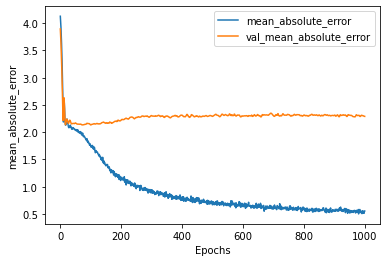

In [10]:
plot_history(history1, 'mean_absolute_error')

In [88]:
y_pred = model1.predict(X_test)

In [89]:
model1.evaluate(X_test, y_test)

[0.66414697 0.78665135 0.77614194 0.39363502 7.55496482 4.69259199
 8.41778036 1.77775675 2.40187552 8.86480884 5.74699222 0.15203723
 9.67635508 5.25870437 2.65330178]
[0.11083026 0.6047768  0.5438263  3.45897    7.119399   6.6704893
 6.5769887  4.121364   6.0357313  8.1196165  5.936111   1.4167961
 5.832543   5.253071   9.4687805 ]
10/10 [==============================] - 0s 5ms/step - loss: 2.0896 - mean_absolute_error: 2.0951


[2.08957839012146, 2.0950520038604736]

In [90]:
#mse_s = mean_squared_error(y_test[:, 0:3], y_pred[:, 0:3])
#print("Mean squared error pour les seuils : " + str(mse_s))

mae_s = mean_absolute_error(y_test[:, 0:3], y_pred[:, 0:3])
print("Mean absolute error pour les seuils : " + str(mae_s))

#mse_v = mean_squared_error(y_test[:, 3:], y_pred[:, 3:])
#print("Mean squared error pour les vitesses : " + str(mse_v))

mae_v = mean_absolute_error(y_test[:, 3:], y_pred[:, 3:])
print("Mean absolute error pour les vitesses : " + str(mae_v))

Mean absolute error pour les seuils : 0.20180587000313646
Mean absolute error pour les vitesses : 2.5615212662779845


Réseau de neurones pour les 3 seuils *model_s* <br/>
Réseau de neurones pour les 12 vitesses *model_v*

In [444]:
y_s = y[:, 0:3]
y_v = y[:, 3:]
print(y_s.shape)
print(y_v.shape)

(5000, 3)
(5000, 12)


In [445]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(dataset, y_s, train_size = 0.7, shuffle = False)
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(dataset, y_v, train_size = 0.7, shuffle = False)

In [446]:
model_s = Sequential()

model_s.add(Dense(units=256, activation='relu', input_shape=(dataset.shape[1], dataset.shape[2])))
model_s.add(Dropout(0.2))

model_s.add(Dense(units=128, activation='relu'))
model_s.add(Dropout(0.2))
model_s.add(Dense(units=128, activation='relu'))
model_s.add(Dropout(0.2))
model_s.add(Dense(units=128, activation='linear'))
model_s.add(Dropout(0.2))
model_s.add(Flatten())

model_s.add(Dense(units=y_s.shape[1]))

model_s.summary()

Model: "sequential_765"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16184 (Dense)         (None, 100, 256)          1024      
                                                                 
 dropout_17388 (Dropout)     (None, 100, 256)          0         
                                                                 
 dense_16185 (Dense)         (None, 100, 128)          32896     
                                                                 
 dropout_17389 (Dropout)     (None, 100, 128)          0         
                                                                 
 dense_16186 (Dense)         (None, 100, 128)          16512     
                                                                 
 dropout_17390 (Dropout)     (None, 100, 128)          0         
                                                                 
 dense_16187 (Dense)         (None, 100, 128)       

In [447]:
input_s = Input(shape = (dataset.shape[1], dataset.shape[2],))
x = Dense(16, activation="relu")(input_s)
x = Dropout(0.1)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(3, activation="linear")(x)

model = Model(inputs=input_s, outputs=x)
adam = Adam(learning_rate = 0.001)

model.compile(loss=MeanAbsoluteError(), optimizer=adam, metrics=[MeanAbsoluteError()])

history_s = model.fit(X_train_s, y_train_s, epochs=1000, batch_size = 64, validation_split=0.3)

y_pred_s = model.predict(X_test_s)
print(mean_absolute_error(y_test_s, y_pred_s))

Epoch 1/1000
39/39 [==============================] - 4s 28ms/step - loss: 0.0158 - mean_absolute_error: 0.0162 - val_loss: 2.5432e-04 - val_mean_absolute_error: 2.5432e-04
Epoch 2/1000
39/39 [==============================] - 0s 11ms/step - loss: 0.0115 - mean_absolute_error: 0.0113 - val_loss: 1.4159e-04 - val_mean_absolute_error: 1.4159e-04
Epoch 3/1000
39/39 [==============================] - 0s 11ms/step - loss: 0.0103 - mean_absolute_error: 0.0104 - val_loss: 1.1368e-04 - val_mean_absolute_error: 1.1368e-04
Epoch 4/1000
39/39 [==============================] - 0s 11ms/step - loss: 0.0097 - mean_absolute_error: 0.0096 - val_loss: 1.5330e-04 - val_mean_absolute_error: 1.5330e-04
Epoch 5/1000
39/39 [==============================] - 0s 10ms/step - loss: 0.0093 - mean_absolute_error: 0.0091 - val_loss: 1.4300e-04 - val_mean_absolute_error: 1.4300e-04
Epoch 6/1000
39/39 [==============================] - 0s 11ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 1.0676e-04 

KeyboardInterrupt: 

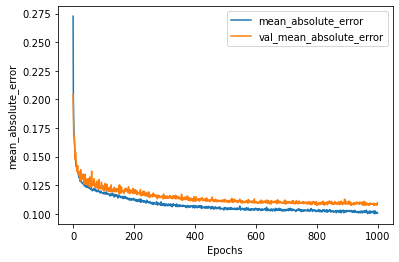

In [420]:
plot_history(history_s, 'mean_absolute_error')

In [135]:
MAX_EPOCHS = 1000

model_v = Sequential()

model_v.add(Dense(units=256, activation='relu', input_shape=(dataset.shape[1], dataset.shape[2])))
model_v.add(Dropout(0.2))

model_v.add(Dense(units=128, activation='relu'))
model_v.add(Dropout(0.2))
model_v.add(Dense(units=128, activation='relu'))
model_v.add(Dropout(0.2))
model_v.add(Dense(units=128, activation='linear'))
model_v.add(Dropout(0.2))
model_v.add(Flatten())

model_v.add(Dense(units=y_v.shape[1]))

model_v.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 10, 256)           1024      
_________________________________________________________________
dropout_70 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
dense_109 (Dense)            (None, 10, 128)           32896     
_________________________________________________________________
dropout_71 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
dense_110 (Dense)            (None, 10, 128)           16512     
_________________________________________________________________
dropout_72 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
dense_111 (Dense)            (None, 10, 128)         

In [136]:
model_s.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanSquaredError()])
model_v.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanSquaredError()])

history_s = model_s.fit(X_train_s, y_train_s, epochs=MAX_EPOCHS, batch_size = 64, validation_split=0.3)
history_v = model_v.fit(X_train_v, y_train_v, epochs=MAX_EPOCHS, batch_size = 64, validation_split=0.3)

#plot_history(history_s, 'mean_squared_error')
#plot_history(history_v, 'mean_squared_error')

Epoch 1/1000
39/39 [==============================] - 2s 19ms/step - loss: 0.2443 - mean_squared_error: 0.0954 - val_loss: 0.1724 - val_mean_squared_error: 0.0514
Epoch 2/1000
39/39 [==============================] - 0s 12ms/step - loss: 0.1819 - mean_squared_error: 0.0531 - val_loss: 0.1582 - val_mean_squared_error: 0.0438
Epoch 3/1000
39/39 [==============================] - 0s 12ms/step - loss: 0.1672 - mean_squared_error: 0.0464 - val_loss: 0.1542 - val_mean_squared_error: 0.0403
Epoch 4/1000
39/39 [==============================] - 1s 13ms/step - loss: 0.1631 - mean_squared_error: 0.0443 - val_loss: 0.1644 - val_mean_squared_error: 0.0453
Epoch 5/1000
39/39 [==============================] - 1s 16ms/step - loss: 0.1576 - mean_squared_error: 0.0416 - val_loss: 0.1561 - val_mean_squared_error: 0.0412
Epoch 6/1000
39/39 [==============================] - 1s 13ms/step - loss: 0.1556 - mean_squared_error: 0.0414 - val_loss: 0.1519 - val_mean_squared_error: 0.0397
Epoch 7/1000
39/39 [==

In [137]:
y_pred_s = model_s.predict(X_test_s)
y_pred_v = model_v.predict(X_test_v)

In [138]:
model_s.evaluate(X_test_s, y_test_s)
model_v.evaluate(X_test_v, y_test_v)

print(mean_absolute_error(y_test_s, y_pred_s))
print(mean_absolute_error(y_test_v, y_pred_v))

[0.47960677 0.36778548 0.5654937 ]
[0.26936275 0.37231544 0.46762797]
0.13171499177391036
2.1558378071539264


In [362]:
dataset.shape[2]

3

In [359]:
def create_model_s(optimizer = 'adam'):
    model_s = Sequential()

    model_s.add(Dense(units=256, activation='relu', input_shape=(dataset.shape[1], dataset.shape[2])))
    model_s.add(Dropout(0.2))

    model_s.add(Dense(units=128, activation='relu'))
    model_s.add(Dropout(0.2))
    model_s.add(Dense(units=128, activation='relu'))
    model_s.add(Dropout(0.2))
    model_s.add(Dense(units=128, activation='linear'))
    model_s.add(Dropout(0.2))
    model_s.add(Flatten())

    model_s.add(Dense(units=y_s.shape[1]))
    
    model_s.compile(loss=MeanAbsoluteError(), optimizer = optimizer, metrics=[MeanSquaredError()])

    return model_s

model = KerasRegressor(model=create_model_s, verbose=0, loss='mean_squared_error')
print(model.get_params().keys())

optimizers = ['rmsprop','adam','SGD']

epochs = [100*k for k in range(1, 11)]
batches = [32, 64, 128]
param_grid = dict(optimizer=optimizers, batch_size=batches, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', verbose=3)
grid_result = grid.fit(X_train_s, y_train_s)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END batch_size=32, epochs=100, optimizer=rmsprop;, score=nan total time=   0.3s
[CV 2/5] END batch_size=32, epochs=100, optimizer=rmsprop;, score=nan total time=   0.3s
[CV 3/5] END batch_size=32, epochs=100, optimizer=rmsprop;, score=nan total time=   0.3s
[CV 4/5] END batch_size=32, epochs=100, optimizer=rmsprop;, score=nan total time=   0.4s
[CV 5/5] END batch_size=32, epochs=100, optimizer=rmsprop;, score=nan total time=   0.2s
[CV 1/5] END batch_size=32, epochs=100, optimizer=adam;, score=nan total time=   0.3s
[CV 2/5] END batch_size=32, epochs=100, optimizer=adam;, score=nan total time=   0.3s
[CV 3/5] END batch_size=32, epochs=100, optimizer=adam;, score=nan total time=   0.3s
[CV 4/5] END batch_si

ValueError: 
All the 450 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972dc0d6a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725095c40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb2d910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724e8fe50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973070ff70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730701220>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa7b8e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972eec3ac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728942520>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97305bfca0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724e6a640>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5cafa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97307013a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97ba168220>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf598430>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729a3b700>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728966e80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5ce7f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5d16a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97303a47c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf598220>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9732539250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972eeacfa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa97040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97305552b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f8cab20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa68730>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973055df70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9732516eb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa6cbe0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972eeb9430>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5cdd30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9817b727f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724dc4c70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724f9f400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730624940>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5caf70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729cdb0a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729ce4fa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a0f3070>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fc14f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973253fb50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97332be970>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973056e910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733287670>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971c52e070>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5ba4f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973306f610>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b427880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724da8a30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973056ea00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729cd2f40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f8bd250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733280b20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b9857c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725071460>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733280670>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9806fad6a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729cd0dc0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724da8f10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724f95b80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973305c2e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730723250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fa6d00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97259f0910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973055df40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973306f1c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724f5c700>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97307232b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fdbf40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b94cf40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa7b940>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9717017040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724f60f40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a677580>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973306f580>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b96ed60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9717afe460>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb5fc10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725067fd0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730ad6df0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b94dd00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730ae3a30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97173516a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971734daf0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728942040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730af8190>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730afcfa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725011af0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289fa0d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9824d1a130>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b96b070>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724df48b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725001550>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724da88b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289ef400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729cd27c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa84520>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97330499d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289fa4c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972dc1ed60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b94dd90>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a6e3bb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973305cd00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97332a8ac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724e17f70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d947a90>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724dc5d60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a6c1ee0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d946d30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289df9d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d94efa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d94e220>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97330400a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724e130d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729ca4b50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b96e4c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973328b220>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729ca37f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729cbf580>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728966880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97303306a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fc126c10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b460d60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb5c970>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972899f9d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972ee90550>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97228e7250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97228ccac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972ee90100>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f17f310>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cffd3610>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aaac880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97662e40a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730981fa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289664c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9815f27790>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971fb2da00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725097700>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730624700>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728ceaa30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9732436130>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cffd38b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f161040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f670b80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9721943b80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9815f27520>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724872250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289665b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976a830df0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d013be0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976ac39040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97662e4eb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f981c3a06a0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730996550>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97239708e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9821c0e340>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971b4da3a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730541550>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972355f760>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97ff0d4430>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fc126f70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f173bb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730624be0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d12ba60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976df23700>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f981741b5b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976811eaf0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9765cfa040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976ab47730>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f981206de50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f980cd10040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cfff4880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972ec8cc40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97226ec370>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730541700>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97ff0d9100>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972ba83190>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976fb5cd30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97676731c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9717683a90>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fb4dbf70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9815f27a60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724ffc370>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730ae5040>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724830ee0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fe6ca0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9815f27130>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f17fdf0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724dc6340>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fbe250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972373ef70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97f9272e50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97332b69d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97676736a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971bc17100>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f8cab50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972fa2e820>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fc126b20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fbc0a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9807a20730>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730624eb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fe61c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fbe730>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972ffe8dc0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724fe66a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97338f23a0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972ba44d60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b451df0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a0d0820>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d12ba30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5d19d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b451880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9732415430>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9767673880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aaac0a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9717684b20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972be9a490>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97227c0400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9809ab7f10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb10280>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972894f5e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa97550>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973060ac10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97324151f0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724dcfc70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb8de50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa97940>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728999460>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97306f0a30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a64f0d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fb4db280>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971fb835e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9817b7da60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa27310>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976811ec70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725071b50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cffe0b20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973072ad00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724d99490>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97227c1940>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97303a7d90>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728965790>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a64ff70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9824d343a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f119520>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728966a30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730b1d280>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730b0a2e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a64f610>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973090bbe0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b9adaf0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97338f2340>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725a13a00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97303a7970>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdf2c160>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cffe09d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730b0a940>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f4562e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97ced72760>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cedddac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a64fe80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9732415c10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972ba8d0a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97227c79a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97c8e5a100>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976772b820>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730c11460>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f981a39e9d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9824d05c40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9717683eb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9767cf6850>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cfcd4ee0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9766b7ce50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972fe9af40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730bffa00>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97c8aedfa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fc6eb250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730c143a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d97fbe0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f3eed90>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728cd8400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f855d60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9824d05e20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdf38760>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf72a100>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725a82fd0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cffe0d90>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb8dfa0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cfcd4130>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f981d22c5b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f4560d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d1091f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9717683fd0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97681fc700>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f303ac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdb831c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdb83280>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976df23bb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9815f0e340>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729209310>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9717b14760>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971b4b41c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdeba400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cfff4ac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972f556df0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972fac7250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973017db50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724e17af0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9806be3d30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9817b994c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725a954f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725a82a30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976617bac0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976617b670>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9821c17c40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9767499b80>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97256411c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976782d400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976766b6d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733a5eb20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97250715e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973136dee0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972eca0130>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb8d580>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9824ee80d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d94f4c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972dc17a30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f981254e250>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cde07880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725a77460>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9767cf6dc0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729ca3550>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f981d22c5e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9767a2bf40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97307215e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97305d9430>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976df23190>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a0f37c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b4274c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972fac77c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97235c3910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289c2cd0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971c52ebb0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733a59910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9725a04df0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972dc1e730>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdb86820>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97c8aed370>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5c9400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9731dea2e0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972bb1ef70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b4278e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d94f910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fb0d0070>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971c52ea30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf5cdac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976747e100>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973253d970>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976ac19370>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976d837dc0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972a0d4c70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976dc6c310>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d94fb80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724df4ac0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9724dc59d0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9806f9f4f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b96ea90>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733075df0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdb86640>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b91fa30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729ca3280>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976766bd90>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729cf93a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97307075b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97228c8f10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973071b820>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973328bf40>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f98218b1520>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972895fa60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289427c0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729cd2b50>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728954c70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972894d5b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972dc9b400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d963c70>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b96e550>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf598d30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9824d18fa0>. Data may not match loss function!

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728948b20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728ba2b80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9815f0e2b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973093d4f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cf598280>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9817b99910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730923850>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d13ea60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97289428e0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730935400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97ff1fe970>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9729c83be0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aa94790>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730932d30>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976614fc10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973091f3a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d95c5b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cde07070>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aac5b80>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9767480af0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d938490>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f976748d4f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9816843c10>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733077310>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97fb0d0460>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972894d580>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97338fd220>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972eebe4f0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d95a520>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730721be0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97305db880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aace220>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdb86850>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f971aad1910>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97305f7880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9728964880>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d95ca60>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f973057b2b0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97cdebaf70>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9733043400>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f9730723640>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b952fd0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f97330433a0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b969b20>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972d961af0>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972fac7520>. Data may not match loss function!

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 929, in _fit
    self._check_model_compatibility(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 571, in _check_model_compatibility
    raise ValueError(
ValueError: loss=mean_squared_error but model compiled with <keras.losses.MeanAbsoluteError object at 0x7f972b978b20>. Data may not match loss function!


In [383]:
def create_model_s():
    input_s = Input(shape = (dataset.shape[1], dataset.shape[2],))
    x = Dense(16, activation="relu")(input_s)
    x = Dropout(0.3)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(3, activation="linear")(x)

    model = Model(inputs=input_s, outputs=x)

    model.compile(loss=MeanAbsoluteError(), optimizer='adam', metrics=[MeanAbsoluteError()])

    return model

In [384]:
model = KerasRegressor(model=create_model_s, verbose=0)
print(model.get_params().keys())

#optimizers = ['rmsprop', 'adam','SGD']

epochs = [100*k for k in range(1, 11)]
batches = [32, 64, 128]
param_grid = dict(batch_size=batches, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', verbose=3)
grid_result = grid.fit(X_train_s, y_train_s)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print(grid_result.best_params_)

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........batch_size=32, epochs=100;, score=-0.198 total time=   3.1s
[CV 2/5] END ........batch_size=32, epochs=100;, score=-0.270 total time=   2.7s
[CV 3/5] END ........batch_size=32, epochs=100;, score=-0.246 total time=   2.6s
[CV 4/5] END ........batch_size=32, epochs=100;, score=-0.236 total time=   3.0s
[CV 5/5] END ........batch_size=32, epochs=100;, score=-0.182 total time=   2.5s
[CV 1/5] END ........batch_size=32, epochs=200;, score=-0.191 total time=   4.2s
[CV 2/5] END ........batch_size=32, epochs=200;, score=-0.191 total time=   4.4s
[CV 3/5] END ........batch_size=32, epochs=200;, score=-0.189 total time=   4.5s
[CV 4/5] END ........batch_size=32, epochs=200;, score=-0.195 total time=   

In [385]:
print(grid_result.best_params_)

{'batch_size': 64, 'epochs': 1000}


In [386]:
print(means)
print(params)

[-0.22630359 -0.19052391 -0.19803073 -0.18549171 -0.18422788 -0.18350874
 -0.19035495 -0.18946789 -0.2028634  -0.19110078 -0.20638925 -0.19108511
 -0.18710141 -0.1968804  -0.2078669  -0.19995019 -0.20761048 -0.18694709
 -0.19090448 -0.18225632 -0.18866515 -0.18794918 -0.19957265 -0.19200184
 -0.20046999 -0.19362138 -0.18754122 -0.18811319 -0.1951164  -0.19677013]
[{'batch_size': 32, 'epochs': 100}, {'batch_size': 32, 'epochs': 200}, {'batch_size': 32, 'epochs': 300}, {'batch_size': 32, 'epochs': 400}, {'batch_size': 32, 'epochs': 500}, {'batch_size': 32, 'epochs': 600}, {'batch_size': 32, 'epochs': 700}, {'batch_size': 32, 'epochs': 800}, {'batch_size': 32, 'epochs': 900}, {'batch_size': 32, 'epochs': 1000}, {'batch_size': 64, 'epochs': 100}, {'batch_size': 64, 'epochs': 200}, {'batch_size': 64, 'epochs': 300}, {'batch_size': 64, 'epochs': 400}, {'batch_size': 64, 'epochs': 500}, {'batch_size': 64, 'epochs': 600}, {'batch_size': 64, 'epochs': 700}, {'batch_size': 64, 'epochs': 800}, {'

epochs=1000, batch_size=64

Dropout rate

In [412]:
def create_model_s_rates(dropout_rate, learning_rate):
    input_s = Input(shape = (dataset.shape[1], dataset.shape[2],))
    x = Dense(16, activation="relu")(input_s)
    x = Dropout(dropout_rate)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    x = Dense(3, activation="linear")(x)

    model = Model(inputs=input_s, outputs=x)
    adam = Adam(learning_rate = learning_rate)

    model.compile(loss=MeanAbsoluteError(), optimizer=adam, metrics=[MeanAbsoluteError()])

    return model

model = KerasRegressor(model=create_model_s_rates, verbose=0, batch_size=64, epochs=128, dropout_rate=0.0, learning_rate=0.001)

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2,0.3]

param_grid = dict(learning_rate=learning_rate, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', verbose=3)
grid_result = grid.fit(X_train_s, y_train_s)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END dropout_rate=0.0, learning_rate=0.001;, score=-0.171 total time=   1.1s
[CV 2/5] END dropout_rate=0.0, learning_rate=0.001;, score=-0.169 total time=   1.2s
[CV 3/5] END dropout_rate=0.0, learning_rate=0.001;, score=-0.195 total time=   1.1s
[CV 4/5] END dropout_rate=0.0, learning_rate=0.001;, score=-0.188 total time=   1.0s
[CV 5/5] END dropout_rate=0.0, learning_rate=0.001;, score=-0.187 total time=   1.0s
[CV 1/5] END dropout_rate=0.0, learning_rate=0.01;, score=-0.168 total time=   1.1s
[CV 2/5] END dropout_rate=0.0, learning_rate=0.01;, score=-0.221 total time=   1.0s
[CV 3/5] END dropout_rate=0.0, learning_rate=0.01;, score=-0.185 total time=   1.0s
[CV 4/5] END dropout_rate=0.0, learning_rate=0.01;, score=-0.201 total time=   1.0s
[CV 5/5] END dropout_rate=0.0, learning_rate=0.01;, score=-0.282 total time=   1.0s
[CV 1/5] END dropout_rate=0.0, learning_rate=0.1;, score=-0.258 total time=   1.1s
[CV 2/5] EN

In [413]:
print(grid_result.best_params_)
print(means)

{'dropout_rate': 0.1, 'learning_rate': 0.001}
[-0.18210669 -0.21138303 -0.26293961 -0.16967758 -0.1736602  -0.26425233
 -0.18190399 -0.1942943  -0.26431329 -0.18872228 -0.20171043 -0.26428445]


Réseau de neurones récurrent pour les seuils *model_rnn*

In [144]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(32, input_shape=(dataset.shape[1], dataset.shape[2])))
model_rnn.add(Dense(units=y_s.shape[1]))
model_rnn.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 32)                1152      
_________________________________________________________________
dense_131 (Dense)            (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [55]:
model_rnn.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanSquaredError()])

history_rnn = model_rnn.fit(X_train_s, y_train_s, epochs=1000, batch_size = 64, validation_split=0.3)

Epoch 1/1000
1/1 [==============================] - 1s 904ms/step - loss: 0.7349 - mean_squared_error: 0.7849 - val_loss: 0.7142 - val_mean_squared_error: 0.7486
Epoch 2/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.6878 - mean_squared_error: 0.7027 - val_loss: 0.6813 - val_mean_squared_error: 0.6770
Epoch 3/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.6418 - mean_squared_error: 0.6268 - val_loss: 0.6509 - val_mean_squared_error: 0.6096
Epoch 4/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.5996 - mean_squared_error: 0.5572 - val_loss: 0.6173 - val_mean_squared_error: 0.5457
Epoch 5/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.5600 - mean_squared_error: 0.4939 - val_loss: 0.5809 - val_mean_squared_error: 0.4857
Epoch 6/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.5249 - mean_squared_error: 0.4367 - val_loss: 0.5446 - val_mean_squared_error: 0.4299
Epoch 7/1000
1/1 [===============

In [56]:
y_pred_s = model_rnn.predict(X_test_s)

model_rnn.evaluate(X_test_s, y_test_s)

print(mean_absolute_error(y_test_s, y_pred_s))

0.37807473549980175


Réseau de neurones récurrent pour un seul seuil *model_rnn_sab*

In [124]:
y_sab = y[:, 1]
X_train_sab, X_test_sab, y_train_sab, y_test_sab = train_test_split(dataset, y_sab, train_size = 0.7, shuffle = False)

model_rnn_sab = Sequential()
model_rnn_sab.add(SimpleRNN(32, input_shape=(dataset.shape[1], dataset.shape[2])))
model_rnn_sab.add(Dense(8, activation = 'relu'))
model_rnn_sab.add((Dropout(0.3)))
model_rnn_sab.add(Dense(4, activation = 'relu'))
model_rnn_sab.add((Dropout(0.3)))
model_rnn_sab.add(Dense(2, activation = 'relu'))
model_rnn_sab.add((Dropout(0.3)))
model_rnn_sab.add(Dense(1, activation = 'linear'))
model_rnn_sab.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 32)                1120      
_________________________________________________________________
dense_97 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_59 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_98 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_60 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_99 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_61 (Dropout)         (None, 2)               

In [125]:
model_rnn_sab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanSquaredError()])

history_rnn_sab = model_rnn_sab.fit(X_train_sab, y_train_sab, epochs=1000, batch_size = 64, validation_split=0.3)

Epoch 1/1000
8/8 [==============================] - 1s 32ms/step - loss: 0.6622 - mean_squared_error: 0.6579 - val_loss: 0.5040 - val_mean_squared_error: 0.3380
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.5094 - mean_squared_error: 0.3522 - val_loss: 0.4748 - val_mean_squared_error: 0.3110
Epoch 3/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4827 - mean_squared_error: 0.3225 - val_loss: 0.4597 - val_mean_squared_error: 0.2968
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4666 - mean_squared_error: 0.3048 - val_loss: 0.4453 - val_mean_squared_error: 0.2830
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4506 - mean_squared_error: 0.2885 - val_loss: 0.4318 - val_mean_squared_error: 0.2698
Epoch 6/1000
8/8 [==============================] - 0s 19ms/step - loss: 0.4352 - mean_squared_error: 0.2724 - val_loss: 0.4190 - val_mean_squared_error: 0.2571
Epoch 7/1000
8/8 [====================

In [126]:
y_pred_sab = model_rnn_sab.predict(X_test_sab)

model_rnn_sab.evaluate(X_test_sab, y_test_sab)

[0.75118063 0.45268832 0.86766048 0.07141202 0.38640205 0.73308984
 0.51343767 0.06773014 0.41213969 0.13173886]
[[0.3180623 ]
 [0.34323132]
 [0.5920338 ]
 [0.29822248]
 [0.36424762]
 [0.69502807]
 [0.40871206]
 [0.41187322]
 [0.6068244 ]
 [0.29475382]]
10/10 [==============================] - 0s 2ms/step - loss: 0.1746 - mean_squared_error: 0.0456


[0.17458781599998474, 0.04563155025243759]

Réseau de neurones LSTM pour un seul seuil *model_rnn_sab_lstm*

In [128]:
model_rnn_sab_lstm = Sequential()
model_rnn_sab_lstm.add(LSTM(units = 4, input_shape = (dataset.shape[1], dataset.shape[2])))
model_rnn_sab_lstm.add(Dense(units=1))
model_rnn_sab_lstm.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 4)             112       
_________________________________________________________________
dense_102 (Dense)            (None, 10, 1)             5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [129]:
model_rnn_sab_lstm.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanSquaredError()])

history_rnn_sab_lstm = model_rnn_sab_lstm.fit(X_train_sab, y_train_sab, epochs=1000, batch_size = 64, validation_split=0.3)

Epoch 1/1000
8/8 [==============================] - 3s 106ms/step - loss: 0.5917 - mean_squared_error: 0.4565 - val_loss: 0.5484 - val_mean_squared_error: 0.3999
Epoch 2/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.5369 - mean_squared_error: 0.3912 - val_loss: 0.4956 - val_mean_squared_error: 0.3406
Epoch 3/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.4859 - mean_squared_error: 0.3335 - val_loss: 0.4486 - val_mean_squared_error: 0.2892
Epoch 4/1000
8/8 [==============================] - 0s 36ms/step - loss: 0.4413 - mean_squared_error: 0.2845 - val_loss: 0.4084 - val_mean_squared_error: 0.2458
Epoch 5/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.4042 - mean_squared_error: 0.2427 - val_loss: 0.3758 - val_mean_squared_error: 0.2109
Epoch 6/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.3751 - mean_squared_error: 0.2102 - val_loss: 0.3500 - val_mean_squared_error: 0.1834
Epoch 7/1000
8/8 [===============

In [130]:
y_pred_sab = model_rnn_sab_lstm.predict(X_test_sab)

model_rnn_sab_lstm.evaluate(X_test_sab, y_test_sab)

[0.75118063 0.45268832 0.86766048 0.07141202 0.38640205 0.73308984
 0.51343767 0.06773014 0.41213969 0.13173886]
[[[0.5258635 ]
  [0.5072272 ]
  [0.44086733]
  [0.3785783 ]
  [0.14119187]
  [0.22729665]
  [0.18374458]
  [0.18418533]
  [0.18059209]
  [0.18097076]]

 [[0.5258635 ]
  [0.21338949]
  [0.19535144]
  [0.18268816]
  [0.17148077]
  [0.17377713]
  [0.17832723]
  [0.19732882]
  [0.23232324]
  [0.23965411]]

 [[0.5258635 ]
  [0.5072272 ]
  [0.44086733]
  [0.3785783 ]
  [0.32260758]
  [0.5453842 ]
  [0.44603777]
  [0.4901899 ]
  [0.40648717]
  [0.57174456]]

 [[0.5258635 ]
  [0.12441817]
  [0.09232467]
  [0.2002886 ]
  [0.08425954]
  [0.16067599]
  [0.20657784]
  [0.23760933]
  [0.2532969 ]
  [0.23994486]]

 [[0.5258635 ]
  [0.3195238 ]
  [0.2815116 ]
  [0.48985597]
  [0.44425893]
  [0.46274725]
  [0.497223  ]
  [0.54754794]
  [0.5413821 ]
  [0.5308859 ]]

 [[0.5258635 ]
  [0.55248106]
  [0.5377258 ]
  [0.59055376]
  [0.67385054]
  [0.75785124]
  [0.75717914]
  [0.7074052 ]
  [0.74

[0.18027937412261963, 0.05370888486504555]

Réseau de neurones à nb-1 entrées pour le seuil ab *model_ab*

In [429]:
dataset_ab = np.zeros((n_sim, nb-1, 2, 2))

for k1 in range(n_sim):
    for k2 in range(nb-1):
        dataset_ab[k1, k2, 0, 0] = dataset[k1, k2, 0]
        dataset_ab[k1, k2, 1, 0] = dataset[k1, k2+1, 0]
        dataset_ab[k1, k2, 0, 1] = dataset[k1, k2, 1]
        dataset_ab[k1, k2, 1, 1] = dataset[k1, k2+1, 1]

X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(dataset_ab, y[:, 1], train_size = 0.7, shuffle = False)

X_train = []
X_test = []

for k in range (nb-1):
    X_train += [X_train_ab[:, k, :]]
    X_test += [X_test_ab[:, k, :]]

In [424]:
print(len(X_train[0]))
print(np.shape(X_train_ab))
print(len(y_train_ab))
print(X_train[0][0])

3500
(3500, 99, 2, 2)
3500
[[0.5        0.7       ]
 [0.30129454 0.77527517]]


In [425]:
X_train_2 = [0]*(3500)
X_test_2 = [0]*(1500)
for k in range (len(X_train[0])):
    X_train_2[k] = []
    for i in range(nb-1):
        X_train_2[k] += [X_train_ab[k, i, :]]
for k in range (len(X_test[0])):
    X_test_2[k] = []
    for i in range(nb-1):
        X_test_2[k] += [X_test_ab[k, i, :]]

In [431]:
list_input = []
list_output = []
for k in range (nb-1):
    input_k = Input(shape = (2, 2,))
    x = SimpleRNN(32)(input_k)
    x = Dropout(0.3)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Model(inputs=input_k, outputs=x)
    list_output += [x.output]
    list_input += [x.input]

output_N1 = concatenate(list_output)

z = Dense(4, activation="relu")(output_N1)
z = Dense(2, activation="relu")(z)
z = Dense(1, activation="linear")(z)

model_ab = Model(inputs=list_input, outputs=z)

model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

history_ab = model_ab.fit(x=X_train, y=y_train_ab, epochs=1000, batch_size = 64, validation_split=0.3)

y_pred_ab = model_ab.predict(X_test)

print(mean_absolute_error(y_pred_ab, y_test_ab))

Epoch 1/1000
39/39 [==============================] - 116s 399ms/step - loss: 0.4870 - mean_absolute_error: 0.4869 - val_loss: 0.4538 - val_mean_absolute_error: 0.4545
Epoch 2/1000
39/39 [==============================] - 3s 82ms/step - loss: 0.4447 - mean_absolute_error: 0.4419 - val_loss: 0.4211 - val_mean_absolute_error: 0.4218
Epoch 3/1000
39/39 [==============================] - 3s 81ms/step - loss: 0.4142 - mean_absolute_error: 0.4145 - val_loss: 0.3930 - val_mean_absolute_error: 0.3936
Epoch 4/1000
39/39 [==============================] - 3s 84ms/step - loss: 0.3877 - mean_absolute_error: 0.3877 - val_loss: 0.3684 - val_mean_absolute_error: 0.3690
Epoch 5/1000
39/39 [==============================] - 4s 95ms/step - loss: 0.3649 - mean_absolute_error: 0.3641 - val_loss: 0.3472 - val_mean_absolute_error: 0.3478
Epoch 6/1000
39/39 [==============================] - 3s 85ms/step - loss: 0.3451 - mean_absolute_error: 0.3464 - val_loss: 0.3288 - val_mean_absolute_error: 0.3295
Epoch 7

KeyboardInterrupt: 

Grid Search pour les paramètres

In [439]:
def create_model(batch_size=64, epochs=1000):
    list_input = []
    list_output = []
    for k in range (nb-1):
        input_k = Input(shape=(2, 2,))
        x = SimpleRNN(32)(input_k)
        x = Dropout(0.3)(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Dense(8, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Model(inputs=input_k, outputs=x)
        list_output += [x.output]
        list_input += [x.input]

    output_N1 = concatenate(list_output)

    z = Dense(4, activation="relu")(output_N1)
    z = Dense(2, activation="relu")(z)
    z = Dense(1, activation="linear")(z)

    model_ab = Model(inputs=list_input, outputs=z)

    model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

    return model_ab

model = KerasRegressor(build_fn=create_model, verbose=0)

batch_sizes = [32, 64, 128]
epochs = [500, 1000, 2000, 3000, 4000, 5000]
param_grid = dict(batch_size=batch_sizes, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
grid_result = grid.fit([X_train[k] for k in range(nb-1)], y_train_ab)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ValueError: Found input variables with inconsistent numbers of samples: [99, 3500]

In [442]:
[X_train[k] for k in range(nb-1)]

[array([[[0.5       , 0.7       ],
         [0.30129454, 0.77527517]],
 
        [[0.5       , 0.7       ],
         [0.39897608, 0.79912604]],
 
        [[0.5       , 0.7       ],
         [0.46690502, 0.70407693]],
 
        ...,
 
        [[0.5       , 0.7       ],
         [0.44965728, 0.75086266]],
 
        [[0.5       , 0.7       ],
         [0.62967044, 0.88335049]],
 
        [[0.5       , 0.7       ],
         [0.45495482, 0.57778251]]]),
 array([[[0.30129454, 0.77527517],
         [0.3733772 , 0.85055034]],
 
        [[0.39897608, 0.79912604],
         [0.29795215, 0.89825208]],
 
        [[0.46690502, 0.70407693],
         [0.43381004, 0.70815387]],
 
        ...,
 
        [[0.44965728, 0.75086266],
         [0.39931456, 0.80172531]],
 
        [[0.62967044, 0.88335049],
         [0.77566823, 0.79094437]],
 
        [[0.45495482, 0.57778251],
         [0.40990963, 0.45556502]]]),
 array([[[0.3733772 , 0.85055034],
         [0.44840825, 0.9258255 ]],
 
        [[0.29795215,

In [ ]:
def create_model(dropout_rate=0.3, learning_rate=0.001):
    list_input = []
    list_output = []
    for k in range (nb-1):
        input_k = Input(shape=(2, 2,))
        x = SimpleRNN(32)(input_k)
        x = Dropout(dropout_rate)(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(8, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
        x = Flatten()(x)
        x = Model(inputs=input_k, outputs=x)
        list_output += [x.output]
        list_input += [x.input]

    output_N1 = concatenate(list_output)

    z = Dense(4, activation="relu")(output_N1)
    z = Dense(2, activation="relu")(z)
    z = Dense(1, activation="linear")(z)

    model_ab = Model(inputs=list_input, outputs=z)

    optimizer = Adam(learning_rate=learning_rate)
    model_ab.compile(loss=MeanAbsoluteError(), optimizer=optimizer, metrics=[MeanAbsoluteError()])

    history_ab = model_ab.fit(x=X_train, y=y_train_ab, epochs=1000, batch_size=64, validation_split=0.3)

    return model_ab

model = KerasRegressor(build_fn=create_model, verbose=0)

dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
learning_rates = [0.001, 0.01, 0.1]
param_grid = dict(dropout_rate=dropout_rates, learning_rate=learning_rates)

# Utiliser GridSearchCV pour effectuer la recherche de grille
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train_ab)

# Afficher les résultats de la recherche de grille
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [376]:
def create_model(optimizer='adam'):
    list_input = []
    list_output = []
    for k in range (nb-1):
        input_k = Input(shape = (2, 2,))
        x = SimpleRNN(32)(input_k)
        x = Dropout(0.3)(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Dense(8, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Model(inputs=input_k, outputs=x)
        list_output += [x.output]
        list_input += [x.input]

    output_N1 = concatenate(list_output)

    z = Dense(4, activation="relu")(output_N1)
    z = Dense(2, activation="relu")(z)
    z = Dense(1, activation="linear")(z)

    model_ab = Model(inputs=list_input, outputs=z)

    model_ab.compile(loss=MeanAbsoluteError(), optimizer=optimizer, metrics=[MeanAbsoluteError()])

    return model_ab

In [322]:
len(X_train)

99

In [379]:
epochs = [1000*k for k in range(1,5)]
batch_size = [32, 64]
param_grid = {'epochs' : epochs, 'batch_size' : batch_size}

model = KerasRegressor(model=create_model, verbose=0, loss='mean_absolute_error')
print(model.get_params().keys())

grid_result = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=3).fit(X_train_2, y_train_ab)
print(grid_result.best_params_)

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])
Fitting 5 folds for each of 8 candidates, totalling 40 fits


ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_99" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_199" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_299" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_399" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_499" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_599" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_699" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_799" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_899" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]


--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/opt/anaconda3/lib/python3.8/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_999" expects 99 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 99, 2, 2) dtype=float32>]



MAE en fonction du nombre de simulations

In [ ]:
list_mae = []
#list_sim = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
list_sim = [100, 500, 1000]
for nsim in list_sim:
    dataset_ab = np.zeros((nsim, nb-1, 2, 2))

    for k1 in range(nsim):
        for k2 in range(nb-1):
            dataset_ab[k1, k2, 0, 0] = dataset[k1, k2, 0]
            dataset_ab[k1, k2, 1, 0] = dataset[k1, k2+1, 0]
            dataset_ab[k1, k2, 0, 1] = dataset[k1, k2, 1]
            dataset_ab[k1, k2, 1, 1] = dataset[k1, k2+1, 1]
            
    X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(dataset_ab, y[:nsim, 1], train_size = 0.7, shuffle = False)

    X_train = []
    X_test = []

    for k in range (nb-1):
        X_train += [X_train_ab[:, k, :]]
        X_test += [X_test_ab[:, k, :]]
    
    list_input = []
    list_output = []
    for k in range (nb-1):
        input_k = Input(shape = (2, 2,))
        x = SimpleRNN(32)(input_k)
        x = Dropout(0.3)(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Dense(8, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Model(inputs=input_k, outputs=x)
        list_output += [x.output]
        list_input += [x.input]

    output_N1 = concatenate(list_output)

    z = Dense(4, activation="relu")(output_N1)
    z = Dense(2, activation="relu")(z)
    z = Dense(1, activation="linear")(z)

    model_ab = Model(inputs=list_input, outputs=z)

    model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

    history_ab = model_ab.fit(x=X_train, y=y_train_ab, epochs=5000, batch_size = 64, validation_split=0.3)

    y_pred_ab = model_ab.predict(X_test)
    
    list_mae += [mean_absolute_error(y_pred_ab, y_test_ab)]

In [ ]:
plt.plot(list_sim, list_mae)
plt.xlabel('Nombre de simulations')
plt.ylabel('Erreur absolue moyenne sur le test set')
plt.title('Sans bruit')
#plt.savefig('mae_sans_bruit',dpi=1200)

État initial et bruit aléatoires

In [293]:
n_sim = 2000
nb = 100

col2 = ["sca", "sab", "sbc", "vac0a0", "vac0a1", 
       "vac1a0", "vac1a1", "vba0b0", "vba0b1", "vba1b0", "vba1b1", "vcb0c0", 
       "vcb0c1", "vcb1c0", "vcb1c1"]
dataset = np.zeros((n_sim, nb, 3))
y = np.zeros((n_sim, len(col2)))
param = np.zeros((n_sim, 6))

for k in range(n_sim):
    print(k)
    list_entite = ['a','b','c']
    max_level = dict()
    max_level['a'] = 1
    max_level['b'] = 1
    max_level['c'] = 1

    list_colums = []
    list_colums = list_colums + list_entite
    for one_ele in list_entite:
        list_colums = list_colums + ['c_'+one_ele]
    celerities = pd.DataFrame(columns=list_colums)

    sca = random.uniform(0, 1)
    scmax = 1
    sab = random.uniform(0, 1)
    samax = 1
    sbc = random.uniform(0, 1)
    sbmax = 1

    vac0a0=random.uniform(0, 10)
    vac0a1=random.uniform(0, 10)
    vac1a0=random.uniform(0, 10)
    vac1a1=random.uniform(0, 10)
    vba0b0=random.uniform(0, 10)
    vba0b1=random.uniform(0, 10)
    vba1b0=random.uniform(0, 10)
    vba1b1=random.uniform(0, 10)
    vcb0c0=random.uniform(0, 10)
    vcb0c1=random.uniform(0, 10)
    vcb1c0=random.uniform(0, 10)
    vcb1c1=random.uniform(0, 10)

    num = 20
    initial_state  = (random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 1))

    noise1 = random.uniform(0, 0.4)
    noise2 = random.uniform(0, 0.4)
    noise3 = random.uniform(0, 0.4)

    cac0a0=vac0a0/(sab - 0)
    cac0a1=vac0a1/(samax - sab)
    cac1a0=vac1a0/(sab - 0)
    cac1a1=vac1a1/(samax - sab)
    cba0b0=vba0b0/(sbc - 0)
    cba0b1=vba0b1/(sbmax - sbc)
    cba1b0=vba1b0/(sbc - 0)
    cba1b1=vba1b1/(sbmax - sbc)
    ccb0c0=vcb0c0/(sca - 0)
    ccb0c1=vcb0c1/(scmax -sca)
    ccb1c0=vcb1c0/(sca - 0)
    ccb1c1=vcb1c1/(scmax -sca)

    df1 = pd.DataFrame([[0,0,0,cac0a0,cba0b0,ccb0c0]],columns=list_colums)
    df2 = pd.DataFrame([[0,0,1,-cac1a0,cba0b0,ccb0c1]],columns=list_colums)
    df3 = pd.DataFrame([[0,1,0,cac0a0,cba0b1,-ccb1c0]],columns=list_colums)
    df4 = pd.DataFrame([[0,1,1,-cac1a0,cba0b1,-ccb1c1]],columns=list_colums)
    df5 = pd.DataFrame([[1,0,0,cac0a1,-cba1b0,ccb0c0]],columns=list_colums)
    df6 = pd.DataFrame([[1,0,1,-cac1a1,-cba1b0,ccb0c1]],columns=list_colums)
    df7 = pd.DataFrame([[1,1,0,cac0a1,-cba1b1,-ccb1c0]],columns=list_colums)
    df8 = pd.DataFrame([[1,1,1,-cac1a1,-cba1b1,-ccb1c1]],columns=list_colums)

    celerities = celerities.append(df1)
    celerities = celerities.append(df2)
    celerities = celerities.append(df3)
    celerities = celerities.append(df4)
    celerities = celerities.append(df5)
    celerities = celerities.append(df6)
    celerities = celerities.append(df7)
    celerities = celerities.append(df8)
    celerities['signature'] = celerities.apply(get_signature,axis=1)

    ini_discrete = ''
    ini_fractional = []
    if initial_state[0]>=sab:
        ini_discrete = ini_discrete+'1'
        ini_fractional = ini_fractional + [(initial_state[0]-sab)/(samax - sab)]
    elif initial_state[0]<sab:
        ini_discrete = ini_discrete+'0'
        ini_fractional = ini_fractional + [initial_state[0]/sab]

    if initial_state[1]>=sbc:
        ini_discrete = ini_discrete+'1'
        ini_fractional = ini_fractional + [(initial_state[1]-sbc)/(sbmax - sbc)]
    elif initial_state[1]<sbc:
        ini_discrete = ini_discrete+'0'
        ini_fractional = ini_fractional + [initial_state[1]/sbc]

    if initial_state[2]>=sca:
        ini_discrete = ini_discrete+'1'
        ini_fractional = ini_fractional + [(initial_state[2]-sca)/(scmax - sca)]
    elif initial_state[2]<sca:
        ini_discrete = ini_discrete+'0'
        ini_fractional = ini_fractional + [initial_state[2]/sca]

    data,t = simulation(ini_discrete,ini_fractional,num)
    real_data = dc(data)
    for i in range(data.shape[0]):
        if data[i][0] < 1:
            real_data[i][0] = data[i][0]*sab
        elif data[i][0] >= 1:
            real_data[i][0] = (data[i][0] - 1)*(samax - sab) + sab
        if data[i][1] < 1:
            real_data[i][1] = data[i][1]*sbc
        elif data[i][1] >= 1:
            real_data[i][1] = (data[i][1] - 1)*(sbmax - sbc) + sbc
        if data[i][2] < 1:
            real_data[i][2] = data[i][2]*sca
        elif data[i][2] >= 1:
            real_data[i][2] = (data[i][2] - 1)*(scmax - sca) + sca
    noise_data = np.zeros((nb+1,3))
    delta_t = t[-1][0]/nb
    new_t = np.zeros((nb+1,1))
    for i in range(nb+1):
        new_t[i][0] = i*delta_t
        for j in range(t.shape[0]-1):
            if t[j][0] <= new_t[i][0] and t[j+1][0] >= new_t[i][0]:
                noise_data[i][0] = random.gauss(0,noise1) + real_data[j][0] + (real_data[j+1][0] - real_data[j][0])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
                noise_data[i][1] = random.gauss(0,noise2) + real_data[j][1] + (real_data[j+1][1] - real_data[j][1])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
                noise_data[i][2] = random.gauss(0,noise3) + real_data[j][2] + (real_data[j+1][2] - real_data[j][2])*(new_t[i][0] - t[j][0])/(t[j+1][0] - t[j][0])
                break
    #plt.plot(new_t[0:nb],noise_data[0:nb,0],label='a')
    #plt.plot(new_t[0:nb],noise_data[0:nb,1],label='b')
    #plt.plot(new_t[0:nb],noise_data[0:nb,2],label='c')
    #plt.legend()
    #plt.savefig('simu1',dpi=1200)
    
    dataset[k, :, 0] = noise_data[0:nb,0]
    dataset[k, :, 1] = noise_data[0:nb,1]
    dataset[k, :, 2] = noise_data[0:nb,2]
    
    param[k, :] = [initial_state[0], initial_state[1], initial_state[2], noise1, noise2, noise3]
    y[k, :] = [sca, sab, sbc, vac0a0, vac0a1, vac1a0, vac1a1, 
            vba0b0, vba0b1, vba1b0, vba1b1, vcb0c0, vcb0c1, vcb1c0, vcb1c1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [287]:
dataset_ab = np.zeros((n_sim, nb-1, 2, 2))

for k1 in range(n_sim):
    for k2 in range(nb-1):
        dataset_ab[k1, k2, 0, 0] = dataset[k1, k2, 0]
        dataset_ab[k1, k2, 1, 0] = dataset[k1, k2+1, 0]
        dataset_ab[k1, k2, 0, 1] = dataset[k1, k2, 1]
        dataset_ab[k1, k2, 1, 1] = dataset[k1, k2+1, 1]

In [ ]:
X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(dataset_ab, y[:, 1], train_size = 0.7, shuffle = False)

X_train = []
X_test = []

for k in range (nb-1):
    X_train += [X_train_ab[:, k, :]]
    X_test += [X_test_ab[:, k, :]]

In [161]:
print(np.shape(dataset_ab[:, 0, :, :]))

(100, 2, 2)


In [256]:
list_input = []
list_output = []
for k in range (nb-1):
    input_k = Input(shape = (2, 2,))
    x = SimpleRNN(32)(input_k)
    x = Dropout(0.3)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Model(inputs=input_k, outputs=x)
    list_output += [x.output]
    list_input += [x.input]

output_N1 = concatenate(list_output)

z = Dense(4, activation="relu")(output_N1)
z = Dense(2, activation="relu")(z)
z = Dense(1, activation="linear")(z)

model_ab = Model(inputs=list_input, outputs=z)

model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

history_ab = model_ab.fit(x=X_train, y=y_train_ab, epochs=5000, batch_size = 64, validation_split=0.3)

y_pred_ab = model_ab.predict(X_test)

print(mean_absolute_error(y_pred_ab, y_test_ab))

KeyboardInterrupt: 

In [ ]:
def create_model(batch_size=64, epochs=1000):
    list_input = []
    list_output = []
    for k in range (nb-1):
        input_k = Input(shape=(2, 2,))
        x = SimpleRNN(32)(input_k)
        x = Dropout(0.3)(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Dense(8, activation="relu")(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Model(inputs=input_k, outputs=x)
        list_output += [x.output]
        list_input += [x.input]

    output_N1 = concatenate(list_output)

    z = Dense(4, activation="relu")(output_N1)
    z = Dense(2, activation="relu")(z)
    z = Dense(1, activation="linear")(z)

    model_ab = Model(inputs=list_input, outputs=z)

    model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

    history_ab = model_ab.fit(x=X_train, y=y_train_ab, epochs=epochs, batch_size=batch_size, validation_split=0.3)

    return model_ab

model = KerasRegressor(build_fn=create_model, verbose=0)

# Définir les hyperparamètres pour GridSearchCV
batch_sizes = [32, 64, 128]
epochs = [500, 1000, 2000, 3000, 4000, 5000]
param_grid = dict(batch_size=batch_sizes, epochs=epochs)

# Utiliser GridSearchCV pour effectuer la recherche de grille
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train_ab)

# Afficher les résultats de la recherche de grille
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dropout, Dense, Flatten, concatenate
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

# Définir une fonction qui crée le modèle Keras avec les hyperparamètres donnés
def create_model(dropout_rate=0.3, learning_rate=0.001):
    list_input = []
    list_output = []
    for k in range (nb-1):
        input_k = Input(shape=(2, 2,))
        x = SimpleRNN(32)(input_k)
        x = Dropout(dropout_rate)(x)
        x = Dense(16, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(8, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
        x = Flatten()(x)
        x = Model(inputs=input_k, outputs=x)
        list_output += [x.output]
        list_input += [x.input]

    output_N1 = concatenate(list_output)

    z = Dense(4, activation="relu")(output_N1)
    z = Dense(2, activation="relu")(z)
    z = Dense(1, activation="linear")(z)

    model_ab = Model(inputs=list_input, outputs=z)

    optimizer = Adam(learning_rate=learning_rate)
    model_ab.compile(loss=MeanAbsoluteError(), optimizer=optimizer, metrics=[MeanAbsoluteError()])

    history_ab = model_ab.fit(x=X_train, y=y_train_ab, epochs=1000, batch_size=64, validation_split=0.3)

    return model_ab

# Créer un modèle Keras Wrapper pour être utilisé avec GridSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Définir les hyperparamètres pour GridSearchCV
dropout_rates = [0.1, 0.3, 0.5]
learning_rates = [0.001, 0.01, 0.1]
param_grid = dict(dropout_rate=dropout_rates, learning_rate=learning_rates)

# Utiliser GridSearchCV pour effectuer la recherche de grille
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train_ab)

# Afficher les résultats de la recherche de grille
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


*nb* entrées

In [305]:
liste_dataset_ab_2 = [0]*n_sim
for s in range(n_sim):
    param_array = np.zeros((4))
    param_array[0] = param[s, 0] # état initial a 
    param_array[1] = param[s, 1] # état initial b
    param_array[2] = param[s, 3] # bruit a 
    param_array[3] = param[s, 4] # bruit b 
    liste_dataset_ab_2[s] = [param_array]
    liste_dataset_ab_2[s] += [dataset_ab[s, :, :, :]]
       
X_train_ab_2, X_test_ab_2, y_train_ab_2, y_test_ab_2 = train_test_split(liste_dataset_ab_2, y[:, 1], train_size = 0.7, shuffle = False)

X_train_2 = [0]*nb
X_test_2 = [0]*nb

X_train_2[0] = np.zeros((len(X_train_ab_2), 4))
X_test_2[0] = np.zeros((len(X_test_ab_2), 4))

for s in range(len(X_train_ab_2)):
    X_train_2[0][s] = X_train_ab_2[s][0]

for k in range(nb-1):
    array_k = np.zeros((len(X_train_ab_2), 2, 2))
    for s in range(len(X_train_ab_2)):
        array_k[s, :, :] = X_train_ab_2[s][1][k]
    X_train_2[k+1] = array_k

for k in range(nb-1):
    array_k = np.zeros((len(X_test_ab_2), 2, 2))
    for s in range(len(X_test_ab_2)):
        array_k[s, :, :] = X_test_ab_2[s][1][k]
    X_test_2[k+1] = array_k      

In [306]:
list_input = []
list_output = []

input_param = Input(shape = (4,)) # état initial et bruit
x = Dense(16, activation="relu")(input_param)
x = Dropout(0.3)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.3)(x)
x = Model(inputs=input_param, outputs=x)
list_output += [x.output]
list_input += [x.input]

for k in range (nb-1):
    input_k = Input(shape = (2, 2,))
    x = SimpleRNN(32)(input_k)
    x = Dropout(0.3)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Model(inputs=input_k, outputs=x)
    list_output += [x.output]
    list_input += [x.input]

output_N1 = concatenate(list_output)

z = Dense(4, activation="relu")(output_N1)
z = Dense(2, activation="relu")(z)
z = Dense(1, activation="linear")(z)

model_ab = Model(inputs=list_input, outputs=z)

model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

KeyboardInterrupt: 

In [83]:
model_ab.summary()

Model: "model_1365"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1263 (InputLayer)        [(None, 2, 2)]       0           []                               
                                                                                                  
 input_1264 (InputLayer)        [(None, 2, 2)]       0           []                               
                                                                                                  
 input_1265 (InputLayer)        [(None, 2, 2)]       0           []                               
                                                                                                  
 input_1266 (InputLayer)        [(None, 2, 2)]       0           []                               
                                                                                         

In [ ]:
history_ab = model_ab.fit(x=X_train_2, y=y_train_ab_2, epochs=10000, batch_size = 64, validation_split=0.3)

y_pred_ab_2 = model_ab.predict(X_test_2)

print(mean_absolute_error(y_pred_ab_2, y_test_ab_2))

In [291]:
print(y_pred_ab_2[0:10])
print(y_test_ab_2[0:10])

[[0.5140859]
 [0.5140859]
 [0.5140859]
 [0.5140859]
 [0.5140859]
 [0.5140859]
 [0.5140859]
 [0.5140859]
 [0.5140859]
 [0.5140859]]
[0.83418987 0.98828817 0.68353739 0.74081079 0.89140379 0.69613153
 0.4844527  0.53566795 0.59601383 0.63599096]


In [ ]:
plot_history(history_ab, 'mean_absolute_error')

In [297]:
dataset_ab = np.zeros((n_sim, nb-1, 2, 2))

for k1 in range(n_sim):
    for k2 in range(nb-1):
        dataset_ab[k1, k2, 0, 0] = dataset[k1, k2, 0]
        dataset_ab[k1, k2, 1, 0] = dataset[k1, k2+1, 0]
        dataset_ab[k1, k2, 0, 1] = dataset[k1, k2, 1]
        dataset_ab[k1, k2, 1, 1] = dataset[k1, k2+1, 1]

*nb+3* entrées (état initial a, état initial b, bruit a, bruit b et les observations 2 à 2)

In [298]:
liste_dataset_ab_3 = [0]*n_sim
for s in range(n_sim):
    param_1 = np.zeros((1))
    param_2 = np.zeros((1))
    param_3 = np.zeros((1))
    param_4 = np.zeros((1))
    param_1[0] = param[s, 0] # état initial a 
    param_2[0] = param[s, 1] # état initial b
    param_3[0] = param[s, 3] # bruit a 
    param_4[0] = param[s, 4] # bruit b
    liste_dataset_ab_3[s] = [param_1, param_2, param_3, param_4]
    liste_dataset_ab_3[s] += [dataset_ab[s, :, :, :]]
       
X_train_ab_3, X_test_ab_3, y_train_ab_3, y_test_ab_3 = train_test_split(liste_dataset_ab_3, y[:, 1], train_size = 0.7, shuffle = False)

X_train_3 = [0]*(nb+3)
X_test_3 = [0]*(nb+3)

X_train_3[0] = np.zeros((len(X_train_ab_3), 1))
X_test_3[0] = np.zeros((len(X_test_ab_3), 1))

X_train_3[1] = np.zeros((len(X_train_ab_3), 1))
X_test_3[1] = np.zeros((len(X_test_ab_3), 1))

X_train_3[2] = np.zeros((len(X_train_ab_3), 1))
X_test_3[2] = np.zeros((len(X_test_ab_3), 1))

X_train_3[3] = np.zeros((len(X_train_ab_3), 1))
X_test_3[3] = np.zeros((len(X_test_ab_3), 1))

for s in range(len(X_train_ab_3)):
    X_train_3[0][s] = X_train_ab_3[s][0]
    X_train_3[1][s] = X_train_ab_3[s][1]
    X_train_3[2][s] = X_train_ab_3[s][2]
    X_train_3[3][s] = X_train_ab_3[s][3]
    
for s in range(len(X_test_ab_3)):
    X_test_3[0][s] = X_test_ab_3[s][0]
    X_test_3[1][s] = X_test_ab_3[s][1]
    X_test_3[2][s] = X_test_ab_3[s][2]
    X_test_3[3][s] = X_test_ab_3[s][3]

for k in range(nb-1):
    array_k = np.zeros((len(X_train_ab_3), 2, 2))
    for s in range(len(X_train_ab_3)):
        array_k[s, :, :] = X_train_ab_3[s][4][k]
    X_train_3[k+4] = array_k

for k in range(nb-1):
    array_k = np.zeros((len(X_test_ab_3), 2, 2))
    for s in range(len(X_test_ab_3)):
        array_k[s, :, :] = X_test_ab_3[s][4][k]
    X_test_3[k+4] = array_k      

In [309]:
list_input = []
list_output = []
input_1 = Input(shape = (1,)) # état initial a 
input_2 = Input(shape = (1,)) # état initial b
input_3 = Input(shape = (1,)) # bruit a 
input_4 = Input(shape = (1,)) # bruit b 

x = Dense(16, activation="relu")(input_1)
x = Dropout(0.5)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.5)(x)
x = Model(inputs=input_1, outputs=x)
list_output += [x.output]
list_input += [x.input]

x = Dense(16, activation="relu")(input_2)
x = Dropout(0.5)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.5)(x)
x = Model(inputs=input_2, outputs=x)
list_output += [x.output]
list_input += [x.input]

x = Dense(16, activation="relu")(input_3)
x = Dropout(0.5)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.5)(x)
x = Model(inputs=input_3, outputs=x)
list_output += [x.output]
list_input += [x.input]

x = Dense(16, activation="relu")(input_4)
x = Dropout(0.5)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.5)(x)
x = Model(inputs=input_4, outputs=x)
list_output += [x.output]
list_input += [x.input]

for k in range (nb-1):
    input_k = Input(shape = (2, 2,))
    x = SimpleRNN(32)(input_k)
    x = Dropout(0.5)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Model(inputs=input_k, outputs=x)
    list_output += [x.output]
    list_input += [x.input]

output_N1 = concatenate(list_output)

z = Dense(4, activation="relu")(output_N1)
z = Dense(2, activation="relu")(z)
z = Dense(1, activation="linear")(z)

model_ab = Model(inputs=list_input, outputs=z)

model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

history_ab = model_ab.fit(x=X_train_3, y=y_train_ab_3, epochs=200, batch_size = 64, validation_split=0.3)

y_pred_ab = model_ab.predict(X_test_3)

print(mean_absolute_error(y_pred_ab, y_test_ab_3))

Epoch 1/200
16/16 [==============================] - 108s 960ms/step - loss: 0.3908 - mean_absolute_error: 0.3837 - val_loss: 0.2006 - val_mean_absolute_error: 0.2001
Epoch 2/200
16/16 [==============================] - 1s 72ms/step - loss: 0.2787 - mean_absolute_error: 0.2756 - val_loss: 0.2244 - val_mean_absolute_error: 0.2257
Epoch 3/200
16/16 [==============================] - 1s 74ms/step - loss: 0.2474 - mean_absolute_error: 0.2483 - val_loss: 0.2114 - val_mean_absolute_error: 0.2125
Epoch 4/200
16/16 [==============================] - 2s 99ms/step - loss: 0.2298 - mean_absolute_error: 0.2308 - val_loss: 0.2394 - val_mean_absolute_error: 0.2411
Epoch 5/200
16/16 [==============================] - 1s 88ms/step - loss: 0.2233 - mean_absolute_error: 0.2199 - val_loss: 0.2256 - val_mean_absolute_error: 0.2273
Epoch 6/200
16/16 [==============================] - 1s 85ms/step - loss: 0.2181 - mean_absolute_error: 0.2181 - val_loss: 0.2101 - val_mean_absolute_error: 0.2115
Epoch 7/200
1

KeyboardInterrupt: 

In [307]:
print(y_pred_ab[0:10])
print(y_test_ab_3[0:10])

[[0.2269531 ]
 [0.22026718]
 [0.22501764]
 [0.6226822 ]
 [0.57925713]
 [0.7985209 ]
 [0.44359633]
 [0.32877216]
 [0.22483027]
 [0.16590303]]
[0.09397579 0.2507343  0.49005176 0.60613818 0.2564541  0.23934314
 0.15400659 0.11174209 0.20201491 0.74254792]


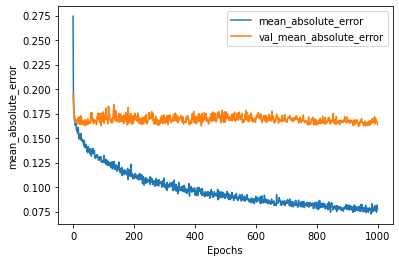

In [308]:
plot_history(history_ab, 'mean_absolute_error')

Réseau avec la score map en entrée et les observations 2 à 2

In [456]:
step = 0.1
score_maps = np.zeros((n_sim, int(1/step), int(1/step)))

for s in range(n_sim):
    for i in range(int(1/step)):
        for j in range(int(1/step)):
            score_maps[s, i, j] = random.uniform(0, 1)

In [507]:
liste_dataset_ab_maps = [0]*n_sim
for s in range(n_sim):
    liste_dataset_ab_maps[s] = [score_maps[s]]
    liste_dataset_ab_maps[s] += [dataset_ab[s, :, :, :]]
       
X_train_ab_maps, X_test_ab_maps, y_train_ab_maps, y_test_ab_maps = train_test_split(liste_dataset_ab_maps, y[:, 1], train_size = 0.7, shuffle = False)  

X_train_ab_maps_2 = [0]*nb
X_train_ab_maps_2[0] = np.zeros((len(X_train_ab_maps), int(1/step), int(1/step)))
for s in range(len(X_train_ab_maps)):
    X_train_ab_maps_2[0][s] = X_train_ab_maps[s][0]
    
for k in range(1, nb):
    X_train_ab_maps_2[k] = np.zeros((len(X_train_ab_maps), 2, 2))
    for s in range(len(X_train_ab_maps)):
        X_train_ab_maps_2[k][s] = X_train_ab_maps[s][1][k-1]

X_test_ab_maps_2 = [0]*nb
X_test_ab_maps_2[0] = np.zeros((len(X_test_ab_maps), int(1/step), int(1/step)))
for s in range(len(X_test_ab_maps)):
    X_test_ab_maps_2[0][s] = X_test_ab_maps[s][0]
    
for k in range(1, nb):
    X_test_ab_maps_2[k] = np.zeros((len(X_test_ab_maps), 2, 2))
    for s in range(len(X_test_ab_maps)):
        X_test_ab_maps_2[k][s] = X_test_ab_maps[s][1][k-1]

In [465]:
list_input = []
list_output = []

input_param = Input(shape = (int(1/step), int(1/step),)) # score map
x = Dense(16, activation="relu")(input_param)
x = Dropout(0.5)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Model(inputs=input_param, outputs=x)

list_output += [x.output]
list_input += [x.input]

for k in range (nb-1):
    input_k = Input(shape = (2, 2,))
    x = SimpleRNN(32)(input_k)
    x = Dropout(0.3)(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Model(inputs=input_k, outputs=x)
    list_output += [x.output]
    list_input += [x.input]

output_N1 = concatenate(list_output)

z = Dense(4, activation="relu")(output_N1)
z = Dense(2, activation="relu")(z)
z = Dense(1, activation="linear")(z)

model_ab = Model(inputs=list_input, outputs=z)

model_ab.compile(loss=MeanAbsoluteError(), optimizer="adam", metrics=[MeanAbsoluteError()])

In [508]:
history_ab = model_ab.fit(x=X_train_ab_maps_2, y=y_train_ab_maps, epochs=200, batch_size = 64, validation_split=0.3)

y_pred_ab = model_ab.predict(X_test_ab_maps_2)

Epoch 1/200
1/1 [==============================] - 135s 135s/step - loss: 0.5792 - mean_absolute_error: 0.5792 - val_loss: 0.4837 - val_mean_absolute_error: 0.4837
Epoch 2/200
1/1 [==============================] - 0s 246ms/step - loss: 0.5719 - mean_absolute_error: 0.5719 - val_loss: 0.4827 - val_mean_absolute_error: 0.4827
Epoch 3/200
1/1 [==============================] - 0s 219ms/step - loss: 0.5680 - mean_absolute_error: 0.5680 - val_loss: 0.4817 - val_mean_absolute_error: 0.4817
Epoch 4/200
1/1 [==============================] - 0s 206ms/step - loss: 0.5670 - mean_absolute_error: 0.5670 - val_loss: 0.4807 - val_mean_absolute_error: 0.4807
Epoch 5/200
1/1 [==============================] - 0s 195ms/step - loss: 0.5660 - mean_absolute_error: 0.5660 - val_loss: 0.4797 - val_mean_absolute_error: 0.4797
Epoch 6/200
1/1 [==============================] - 0s 213ms/step - loss: 0.5650 - mean_absolute_error: 0.5650 - val_loss: 0.4787 - val_mean_absolute_error: 0.4787
Epoch 7/200
1/1 [====

KeyboardInterrupt: 